### Libraries

In [1]:
import os
import re   
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from pymavlog import MavLog
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D


### Logger Class

In [2]:
class PixhawkLogger(MavLog):
    
    def __init__(self, log_path: str):
        super().__init__(log_path)
        self.parse()
        self.message = 'None'
        self.alt = self.msg_cmd_alt()

    @staticmethod
    def timestamp_ms(TimeUS):
        timestamp = TimeUS / 1_000
        return pd.to_datetime(timestamp, unit='ms')

    @staticmethod
    def timestamp_s(TimeUS):
        timestamp = TimeUS / 1_000_000
        return pd.to_datetime(timestamp, unit='s')

    @staticmethod
    def coordinates_distance(ref_lat: float, ref_lon: float, target_lat: float, target_lon: float) -> float :
        coef = 113200
        delta_x = (target_lon - ref_lon) * math.cos(math.radians((ref_lat + target_lat) / 2)) * coef
        delta_y = (target_lat - ref_lat) * coef
        return delta_x, delta_y

    def get_message(self, message: str):
        self.message = message

    def get_all_messages(self):
        messages = self._types
        return messages

    def get_field(self, field: str):
        return self.get(self.message)[field]

    def get_all_fields(self, message: str):
        self.message = message
        fields = list(self._parsed_data[self.message].columns)
        return fields

    def msg_statustext(self):
        self.message = 'MSG'
        messages = self.get_field('Message') 
        return messages

    def msg_cmd_alt(self):
        self.message = 'CMD'
        raw_alt = self.get_field('Alt')
        alt = stats.mode(raw_alt)
        return int(alt.mode[0])

    def msg_nval_names(self):
        self.message = 'NVAL'
        name = self.get_field('Name')
        names = pd.Series(name).dropna().unique().tolist()
        return names

    def msg_baro_df(self):
        self.message = 'BARO'
        raw_time = self.get_field('TimeUS')

        df = pd.DataFrame({
            'timestamp': self.timestamp_s(raw_time),
            'alt': self.get_field('Alt')
        })

        return df.sort_values('timestamp')

    def msg_gps_df(self):
        self.message = 'GPS'
        raw_time = self.get_field('TimeUS')

        df = pd.DataFrame({
            'timestamp': self.timestamp_s(raw_time),
            'lat': self.get_field('Lat'),
            'lon': self.get_field('Lng'),
        })

        return df.sort_values('timestamp')

    def msg_nval_df(self, sensor_type: str='MQ2'):
        self.message = 'NVAL'
        raw_time = self.get_field('TimeUS')

        df = pd.DataFrame({
            'timestamp': self.timestamp_s(raw_time),
            'ppm' : self.get_field('Value'),
            'name': self.get_field('Name').astype(str)
        })

        if sensor_type is None:
            return df.sort_values(by=['name', 'timestamp'])

        df_sensor = df[df['name'].str.contains(sensor_type, case=False)]
        return df_sensor.sort_values(by=['name', 'timestamp']).reset_index()

    def merged_gps_nval(self, sensor_type: str='MQ2', cut_takeoff: bool=True) -> pd.DataFrame:
        df_gps = self.msg_gps_df().sort_values('timestamp')
        df_nval = self.msg_nval_df(sensor_type).sort_values('timestamp')

        df_merged = pd.merge_asof(
            df_gps,
            df_nval,
            on='timestamp',
            direction='nearest',
            tolerance=pd.Timedelta('500ms')
        )

        df_merged = df_merged.dropna()

        if not cut_takeoff:
            return df_merged.sort_values('timestamp')
        
        df_merged['sequence'] = df_merged['name'].apply(lambda x: int(re.search(r'-(\d+)$', str(x)).group(1)))
        mask_takeoff = df_merged['sequence'] == 2
        first_idx = mask_takeoff[mask_takeoff].index[0]

        return df_merged.loc[first_idx:].sort_values('timestamp').reset_index(drop=True)

    @staticmethod
    def reset_timestamp(name: pd.Series, timestamp: pd.Series) -> pd.Series:
        res_time = timestamp.groupby(name).transform(lambda x: x - x.min())
        return pd.Timestamp("00:00:00") + res_time

    @staticmethod
    def relative_timestamp(timestamp: pd.Series) -> pd.Series:
        rel_time =  timestamp - timestamp.min()
        return pd.Timestamp("00:00:00") + rel_time

    def plot_gas(self, 
            sensor_type: str='MQ2', ground_truth: int=3, max_indicator: bool=True, plot_sequence: bool=False, 
            verbose_graph: bool=False, mapping: bool=False, debug_text: bool=False):
        df = self.msg_nval_df(sensor_type)

        if plot_sequence:
            df['timestamp'] = self.reset_timestamp(df['name'], df['timestamp'])
        else:
            df['timestamp'] = self.relative_timestamp(df['timestamp'])


        ppm_max = df['ppm'].max()
        if ppm_max <= 20 :
            shifted_text = 0.2
        else:
            shifted_text = 1.0

        sequence = df['name'].unique().tolist()
        plt.figure(figsize=(12, 6))

        for seq in sequence:
            df_seq = df[df['name'] == seq]
            plt.plot(df_seq['timestamp'], df_seq['ppm'], label=seq)

            if max_indicator:
                max_ppm_value = df_seq['ppm'].max()
                max_ppm_time  = df_seq[df_seq['ppm'] == max_ppm_value]['timestamp'].values[0]
                plt.plot(max_ppm_time, max_ppm_value, 'ro')
                plt.text(
                    max_ppm_time, max_ppm_value + shifted_text, f'{max_ppm_value:.1f}',fontsize=12, 
                    color='red', ha='center', va='center', fontweight='semibold'
                )

        if verbose_graph:
            peak_row = df.loc[df['ppm'].idxmax()]
            peak_time_abs = peak_row['timestamp']

            gt_seq = f"{sensor_type}-{ground_truth}"
            gt_df = df[df['name'] == gt_seq]
            gt_start_time = gt_df['timestamp'].min()

            peak_rel_time = (peak_time_abs - gt_start_time).total_seconds()
            peak_duration = timedelta(seconds=peak_rel_time)
            plot_peak_time = gt_start_time + peak_duration

            plt.axvline(x=plot_peak_time, color='purple', linestyle='--', linewidth=1)
            plt.text(
                0.01, 0.99, f"peak gas: {peak_row['ppm']:.2f} ppm",
                color='red', ha='left', va='top', fontsize=12, fontweight='bold',
                transform=plt.gca().transAxes
            )
            plt.text(
                0.01, 0.95, f'peak time: {peak_rel_time:.2f} detik',
                color='purple', ha='left', va='top', fontsize=12, fontweight='bold',
                transform=plt.gca().transAxes
            )
            
            if debug_text:
                seq_name = f"{sensor_type}-{ground_truth+1}"
                seq_df   = df[df['name'] == seq_name]
                seq_ppm  = seq_df['ppm'].iloc[0]
                seq_time = seq_df['timestamp'].min()
                seq_time_rel = (seq_time - gt_start_time).total_seconds()
                plt.axvline(x=seq_time, color='gray', linestyle='--', linewidth=1)
                plt.text(
                    0.01, 0.9, f'peak start time: {seq_time_rel:.2f} detik',
                    color='gray', ha='left', va='top', fontsize=12, fontweight='bold',
                    transform=plt.gca().transAxes
                )

        plt.title(f'GRAFIK NILAI PPM [{sensor_type if sensor_type is not None else "MQ"} - {self.alt if not mapping else "4"}M]')
        plt.ylabel('PPM')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_peak_gas(self, sensor_type: str='MQ2', max_indicator: bool=True):
        df = self.msg_nval_df(sensor_type)
        df_peak = df.groupby('name')['ppm'].max().reset_index()

        df_peak['sequence'] = df_peak['name'].apply(lambda x: int(re.search(r'-(\d+)$', x).group(1)))
        df_peak['sequence'] = df_peak['sequence'].astype(int)
        df_peak = df_peak.sort_values(by='sequence').reset_index(drop=True)

        ppm_max = df_peak['ppm'].max()
        if ppm_max <= 20 :
            shifted_text = 0.1
        else:
            shifted_text = 1.0

        plt.figure(figsize=(8, 5))
        plt.plot(
            df_peak['sequence'], df_peak['ppm'], 
            marker='o', linestyle='-', color='royalblue',
            linewidth=2, markersize=6
        )

        for i, row in df_peak.iterrows():
            plt.text(
                row['sequence'], row['ppm'] + shifted_text, f'{row["ppm"]:.1f}',
                ha='center', va='bottom', fontsize=12, color='red', fontweight='semibold'
            )

        plt.title(f'GRAFIK NILAI PPM TERTINGGI [{sensor_type if sensor_type is not None else "MQ"} - {self.alt}M]')
        plt.ylabel('Peak PPM')
        plt.xlabel('Sequence')
        plt.grid(True)
        plt.xticks(df_peak['sequence'])
        plt.tight_layout()
        plt.show()

    def plot_mapping_2d(self, sensor_type: str='MQ2', cut_takeoff: bool=True, ground_truth: int=3, verbose_graph: bool=False):
        df = self.merged_gps_nval(sensor_type, cut_takeoff)

        ref_lat = df.iloc[0]['lat']
        ref_lon = df.iloc[0]['lon']

        df['x_meter'], df['y_meter'] = zip(*df.apply(
            lambda row: self.coordinates_distance(ref_lat, ref_lon, row['lat'], row['lon']),
            axis=1
        ))

        peak_row = df.loc[df['ppm'].idxmax()]
        peak_gas = peak_row['ppm']
        peak_time_abs = peak_row['timestamp']
        peak_x = peak_row['x_meter']
        peak_y = peak_row['y_meter']

        gt_seq = f"{sensor_type}-{ground_truth}"
        gt_df = df[df['name'] == gt_seq]
        gt_start_time = gt_df['timestamp'].min()
        peak_time_rel = (peak_time_abs - gt_start_time).total_seconds()

        gt_start_row = gt_df.loc[gt_df['timestamp'].idxmin()]
        gt_start_x = gt_start_row['x_meter']
        gt_start_y = gt_start_row['y_meter']
        dx = peak_x - gt_start_x
        dy = peak_y - gt_start_y
        peak_distance = (dx**2 + dy**2)**0.5

        plt.figure(figsize=(10, 6))

        if verbose_graph:
            info_text = f"""
             Peak Gas      : {peak_gas:.2f} ppm
            Peak Time     : {peak_time_rel:.2f} detik
            Peak Distance : {peak_distance:.2f} m
            """
            plt.text(0.01, 0.99, info_text.strip(), transform=plt.gca().transAxes,
                    ha='left', va='top', fontsize=8, fontweight='bold', color='black',
                    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
        
        sc = plt.scatter(df['x_meter'], df['y_meter'], c=df['ppm'], cmap='hot', s=50)
        plt.colorbar(sc, label='PPM Gas')
        plt.xlabel('Jarak Relatif Horizontal (m)')
        plt.ylabel('Jarak Relatif Vertikal (m)')
        plt.title('Visualisasi 2D')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def plot_mapping_3d(self, sensor_type: str='MQ2', cut_takeoff: bool=True):
        df = self.merged_gps_nval(sensor_type, cut_takeoff)

        ref_lat = df.iloc[0]['lat']
        ref_lon = df.iloc[0]['lon']

        df['x_meter'], df['y_meter'] = zip(*df.apply(
            lambda row: self.coordinates_distance(ref_lat, ref_lon, row['lat'], row['lon']),
            axis=1
        ))

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(df['x_meter'], df['y_meter'], df['ppm'], c=df['ppm'], cmap='plasma')
        ax.set_xlabel('Jarak Relatif Horizontal (m)')
        ax.set_ylabel('Jarak Relatif Vertikal (m)')
        ax.set_zlabel('PPM Gas')
        plt.colorbar(sc, label='PPM Gas')
        plt.title('Visualisasi 3D')
        plt.tight_layout()
        plt.show()

    def plot_mapping_grid(self, sensor_type: str = 'MQ2', x_grid: int=3, y_grid: int=3, const_distance: float=2.5):
        df = self.merged_gps_nval(sensor_type)
        df['sequence'] = df['name'].apply(lambda x: int(re.search(r'-(\d+)$', str(x)).group(1)))
        df_peak = df.groupby('sequence')['ppm'].max().reset_index()

        grid_sequence = [2, 7, 8, 3, 6, 9, 4, 5, 10] 
        matrix = np.full((y_grid, x_grid), np.nan)
        annot_matrix = np.full((y_grid, x_grid), "", dtype=object)

        for idx, seq in enumerate(grid_sequence):
            row = df_peak[df_peak['sequence'] == seq]
            if not row.empty:
                ppm = row['ppm'].values[0]
                x = idx % x_grid
                y = idx // x_grid
                matrix[y, x] = ppm
                annot_matrix[y, x] = f"{ppm:.2f}\nsequence: {seq}"

        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(
            matrix, annot=annot_matrix, fmt="", cmap='YlOrRd',
            cbar_kws={'label': 'PPM Gas'}, linewidths=0.5, linecolor='gray'
        )

        x_labels = [f"{i * const_distance:.1f}" for i in range(x_grid)]
        y_labels = [f"{i * const_distance:.1f}" for i in range(y_grid)]
        
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
        ax.set_title(f"Heatmap Grid ({x_grid}x{y_grid})")
        ax.set_xlabel(f"Grid X - Jarak Relatif Horizontal (m)")
        ax.set_ylabel(f"Grid Y - Jarak Relatif Vertikal (m)")
        plt.tight_layout()
        plt.show()

    def result(self, ground_truth: int=3, sensor_type: str='MQ2'):
        df = self.msg_nval_df(sensor_type)
        peak_row  = df.loc[df['ppm'].idxmax()] 
        peak_name = peak_row['name']
        peak_ppm  = peak_row['ppm']
        peak_time = peak_row['timestamp']
        peak_seq  = int(re.search(r'-(\d+)$', peak_name).group(1))

        gas_seq = f"{sensor_type}-{ground_truth}"
        gas_seq_df = df[df['name'] == gas_seq]
        gas_start_time = gas_seq_df['timestamp'].min()
        peak_relative_time = peak_time - gas_start_time

        result = {
            'alt' : self.alt,
            'sensor': peak_name[:3],
            'peak_seq': peak_seq,
            'peak_ppm': peak_ppm,
            'peak_time': peak_relative_time.total_seconds() 
        }

        return result


### Logger I - ketinggian 1

In [3]:
file_path = "Log_File/Sampling/Ketinggian/Kantin/1_1m.bin"
log = PixhawkLogger(file_path)

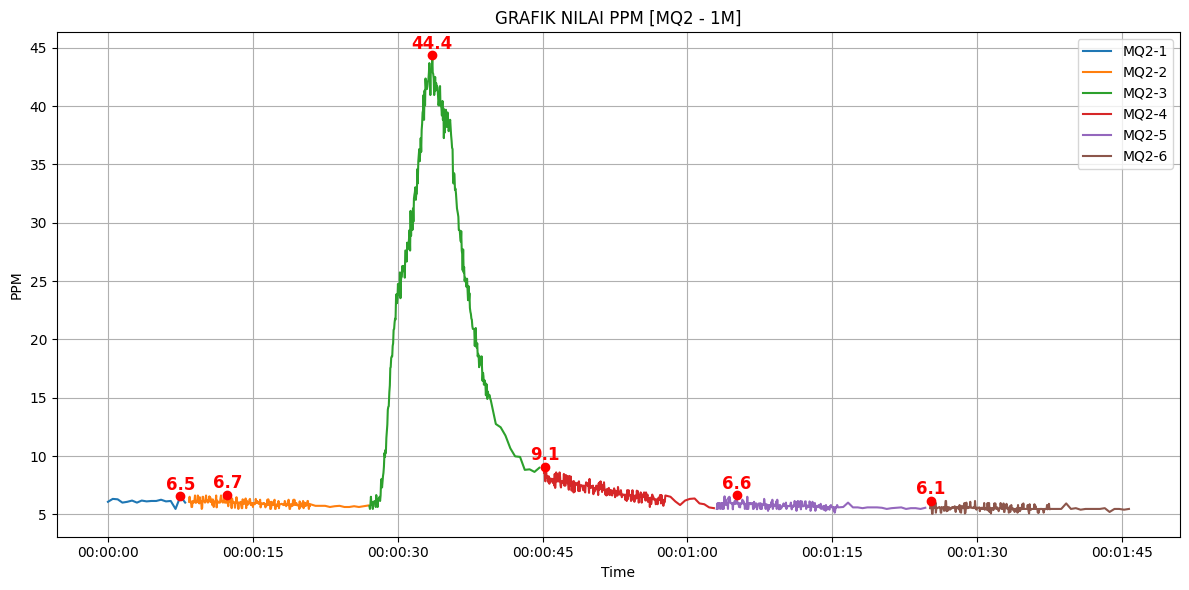

In [4]:
log.plot_gas()

In [5]:
# log.plot_gas(sensor_type='MQ5')

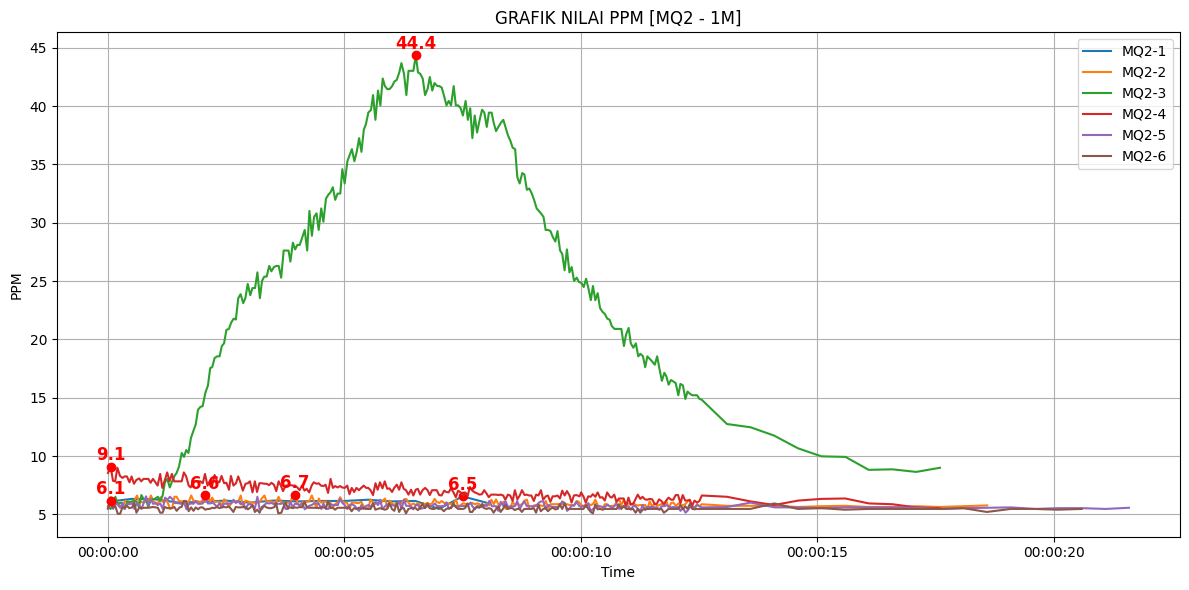

In [6]:
sequences = True
log.plot_gas(plot_sequence=True)

In [7]:
log.result()

{'alt': 1,
 'sensor': 'MQ2',
 'peak_seq': 3,
 'peak_ppm': 44.35000991821289,
 'peak_time': 6.510278}

### Logger II - ketinggian 2

In [8]:
file_path = "Log_File/Sampling/Ketinggian/Kantin/8_5m.bin"
log = PixhawkLogger(file_path)

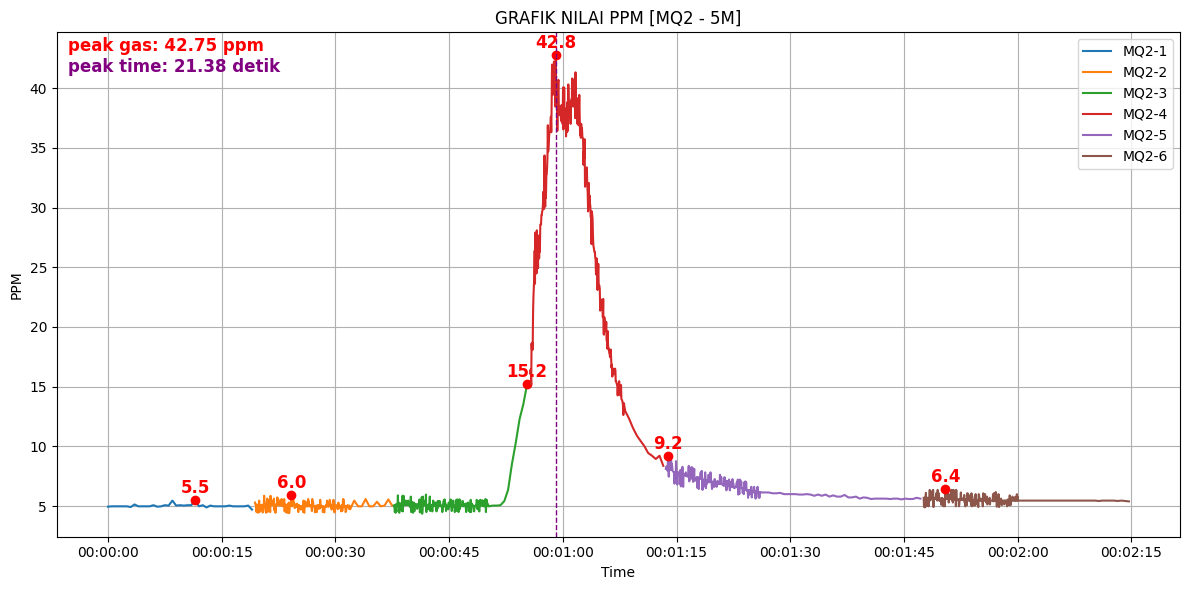

In [9]:
log.plot_gas(verbose_graph=True)

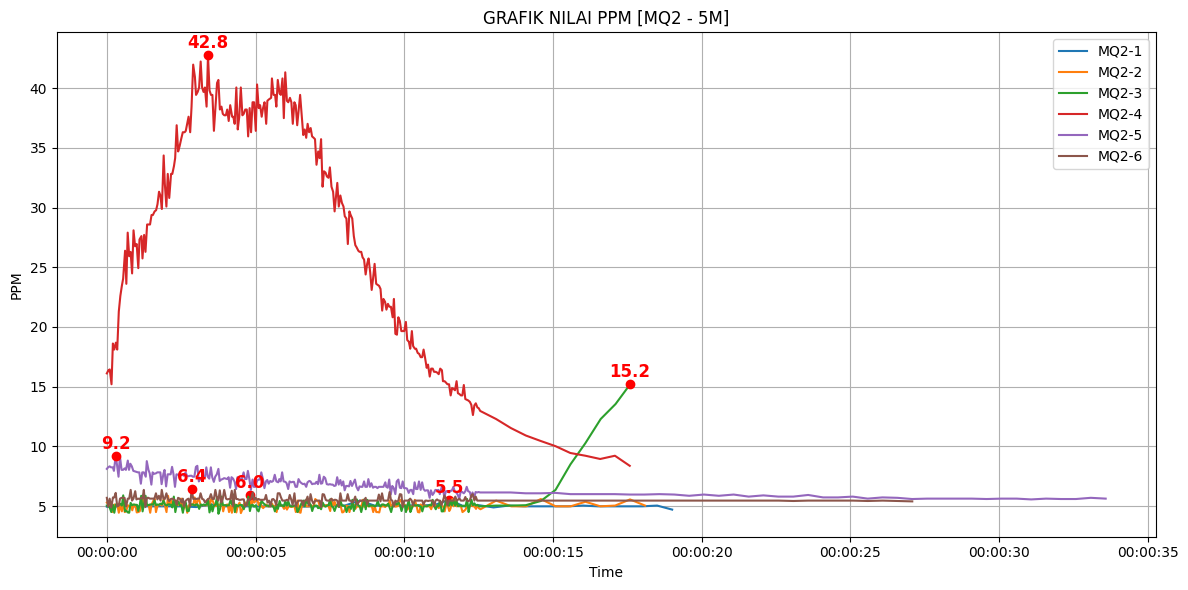

In [10]:
log.plot_gas(plot_sequence=True)

In [11]:
log.result()

{'alt': 5,
 'sensor': 'MQ2',
 'peak_seq': 4,
 'peak_ppm': 42.750953674316406,
 'peak_time': 21.37996}

### Logger III - mapping 1

In [12]:
file_path = "Log_File/Sampling/Mapping/9_seq6.bin"
log = PixhawkLogger(file_path)

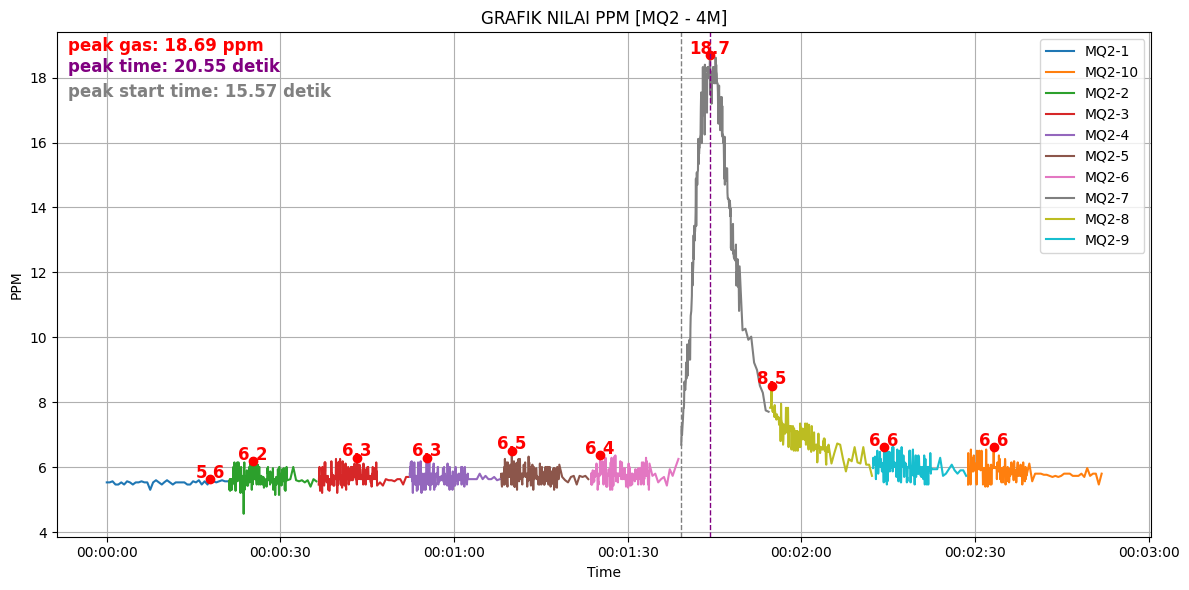

In [13]:
log.plot_gas(ground_truth=6, verbose_graph=True, debug_text=True)

In [14]:
log.result()

{'alt': 4,
 'sensor': 'MQ2',
 'peak_seq': 7,
 'peak_ppm': 18.689682006835938,
 'peak_time': 67.611106}

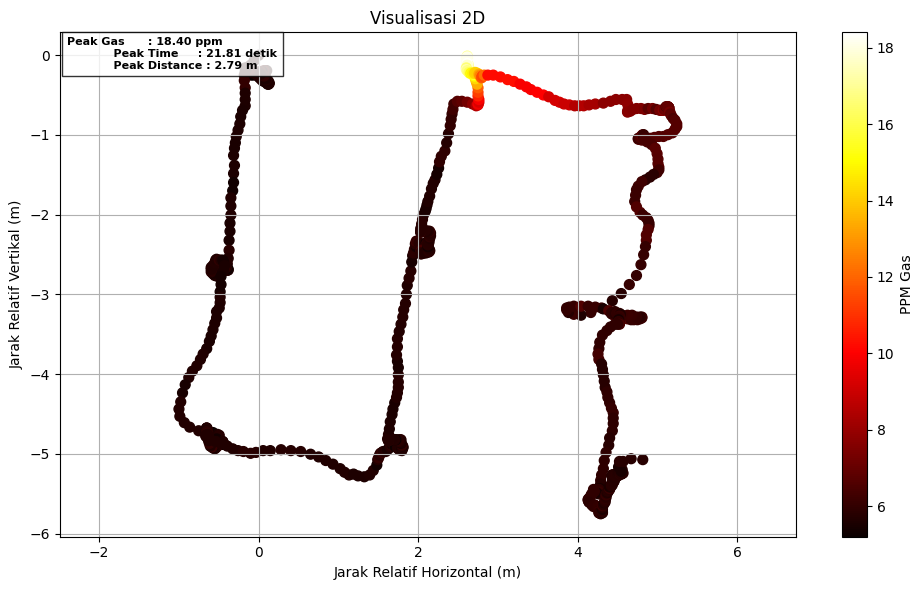

In [15]:
log.plot_mapping_2d(ground_truth=6, verbose_graph=True)

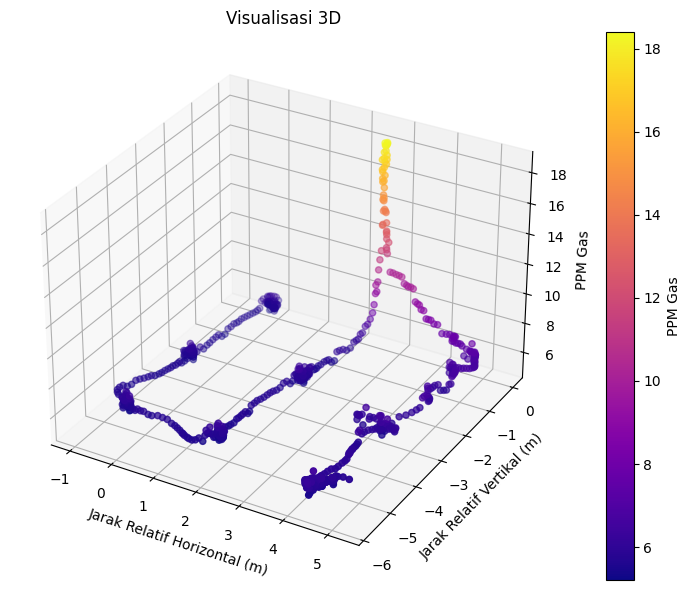

In [16]:
log.plot_mapping_3d()

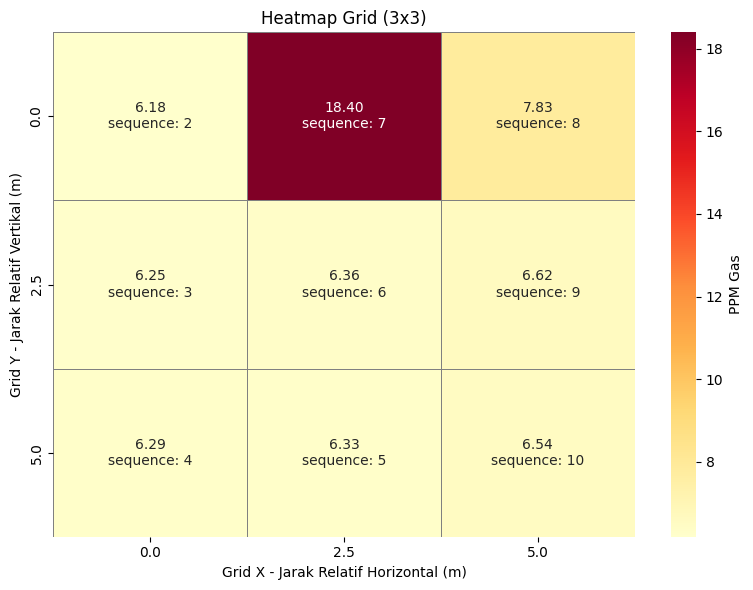

In [17]:
log.plot_mapping_grid()

In [18]:
log.result(ground_truth=7)

{'alt': 4,
 'sensor': 'MQ2',
 'peak_seq': 7,
 'peak_ppm': 18.689682006835938,
 'peak_time': 4.980526}

### Multiple Logger Class

In [19]:
class MultipleLogger:
    
    def __init__(self, folder_path: str):
        self.folder = folder_path
        self.loggers = self._load_loggers()

    def _load_loggers(self):
        loggers = []

        for filename in os.listdir(self.folder):
            if filename.endswith('.bin'):
                full_path = os.path.join(self.folder, filename)
                try:
                    logger = PixhawkLogger(full_path)
                    loggers.append((filename, logger))
                except Exception as e:
                    print(f"[WARNING] Gagal memuat {filename}: {e}")

        return loggers

    def list_logs(self):
        return [fname for fname, _ in self.loggers]

    def total_sequence(self):
        for fname, logger in self.loggers:
            sequence = logger.msg_nval_names()
            print(f"[INFO] Sequence of file : {fname} [{len(sequence)}]")

    def plot_some_gas(self, experiments_num: int=1, sensor_type: str='MQ2', **kwargs):
        for fname, logger in self.loggers:
            match = re.match(r'^\d+', fname)
            if match:
                first_num_str = match.group(0)
                first_num = int(first_num_str)
                if first_num == experiments_num:
                    print(f"[INFO] Plotting gas file : {fname}")                  
                    logger.plot_gas(sensor_type=sensor_type, **kwargs)
        
    def plot_all_gas(self, sensor_type: str='MQ2', **kwargs):
        gt_list = kwargs.pop('ground_truth', None)

        if gt_list is not None and isinstance(gt_list, list):
            for (fname, logger), gt_val in zip(self.loggers, gt_list):
                current_kwargs = kwargs.copy() 
                current_kwargs['ground_truth'] = gt_val 
                print(f"[INFO] Plotting gas file : {fname} [ground truth: {gt_val}]")
                logger.plot_gas(sensor_type=sensor_type, **current_kwargs)
        else:
            for fname, logger in self.loggers:
                print(f"[INFO] Plotting gas file : {fname}")
                logger.plot_gas(sensor_type=sensor_type, **kwargs)

    def plot_all_peak_gas(self, sensor_type: str='MQ2', **kwargs):
        for fname, logger in self.loggers:
            print(f"[INFO] Plotting peak gas file : {fname}")
            logger.plot_peak_gas(sensor_type=sensor_type, **kwargs)

    def plot_avg_peak(self, sensor_type: str='MQ2', **kwargs):
        df_result = self.get_alt_result(sensor_type=sensor_type, verbose=False)
        df_result['alt'] = df_result['alt'].str.replace(' meter', '').astype(int)

        plt.figure(figsize=(8, 5))
        plt.plot(df_result['alt'], df_result['avg_peak_ppm'], marker='o')

        for x, y in zip(df_result['alt'], df_result['avg_peak_ppm']):
            plt.text(
                x, y + 0.1, f'{y:.2f}', ha='center', va='bottom', 
                color='red', fontsize=12, fontweight='semibold')

        plt.xlabel('Altitude (m)')
        plt.ylabel('Rata-rata Gas Tertinggi (ppm)')
        plt.title('GRAFIK RATA-RATA PUNCAK GAS TERHADAP KETINGGIAN')
        plt.grid(True)
        plt.xticks(df_result['alt'])
        plt.tight_layout()
        plt.show()

    def plot_avg_time(self, sensor_type: str='MQ2', **kwargs):
        df_result = self.get_alt_result(sensor_type=sensor_type, verbose=False)
        df_result['alt'] = df_result['alt'].str.replace(' meter', '').astype(int)

        plt.figure(figsize=(8, 5))
        plt.plot(df_result['alt'], df_result['avg_peak_time'], marker='o')

        for x, y in zip(df_result['alt'], df_result['avg_peak_time']):
            plt.text(
                x, y + 0.1, f'{y:.2f}', ha='center', va='bottom', 
                color='red', fontsize=12, fontweight='semibold')

        plt.xlabel('Altitude (m)')
        plt.ylabel('Rata-rata Waktu (detik)')
        plt.title('GRAFIK RATA-RATA DURASI DETEKSI PUNCAK GAS TERHADAP KETINGGIAN')
        plt.grid(True)
        plt.xticks(df_result['alt'])
        plt.tight_layout()
        plt.show()

    def plot_error_relatif(self, ground_truth: int = 3, sensor_type: str = 'MQ2'):
        df_summary = self.get_summary(sensor_type=sensor_type)
        df_alt = df_summary.groupby('alt')
        error_data = []

        for alt, group in df_alt:
            incorrect_count = sum(group['peak_seq'] != ground_truth)
            error = incorrect_count / len(group) * 100
            error_data.append((alt, error))

        df_error = pd.DataFrame(error_data, columns=['alt', 'relative_error'])

        plt.figure(figsize=(8, 5))
        bars = plt.bar(df_error['alt'], df_error['relative_error'], color='tomato')
        plt.title('GRAFIK PERSENTASE GALAT RELATIF TIAP KETINGGIAN')
        plt.xlabel('Ketinggian (m)')
        plt.ylabel('Galat Relatif (%)')
        plt.xticks(df_error['alt'])
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f"{height:.1f}%", ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()

    def plot_gas_per_alt(self, ground_truth=3, sensor_type='MQ2'):
        df = self.get_summary(ground_truth=ground_truth, sensor_type=sensor_type)
        df['trial'] = df['file'].apply(lambda x: int(re.match(r'(\d+)_', x).group(1)))
        df_alt = df.groupby('alt')

        for alt, group in sorted(df_alt):
            group_sorted = group.sort_values('trial')
            x = group_sorted['trial']
            y = group_sorted['peak_ppm']

            plt.figure(figsize=(8, 5))
            bars = plt.bar(x, y, color='skyblue', edgecolor='black')
            plt.title(f'GRAFIK PUNCAK KONSENTRASI GAS KETINGGIAN {alt} METER')
            plt.xlabel('Percobaan')
            plt.ylabel('PPM')
            plt.xticks(x)

            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}',
                        ha='center', va='bottom', fontsize=9, fontweight='semibold')

            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    def plot_time_per_alt(self, ground_truth=3, sensor_type='MQ2'):
        df = self.get_summary(ground_truth=ground_truth, sensor_type=sensor_type)
        df['trial'] = df['file'].apply(lambda x: int(re.match(r'(\d+)_', x).group(1)))
        df_alt = df.groupby('alt')

        for alt, group in sorted(df_alt):
            group_sorted = group.sort_values('trial')
            y_labels = group_sorted['trial']
            x_values = group_sorted['peak_time']

            plt.figure(figsize=(8, 5))
            bars = plt.barh(y_labels, x_values, color='lightgreen', edgecolor='black')
            plt.title(f'GRAFIK DURASI PENCAPAIAN PUNCAK GAS KETINGGIAN {alt} METER')
            plt.xlabel('Time (s)')
            plt.ylabel('Percobaan')
            plt.yticks(y_labels)

            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.2, bar.get_y() + bar.get_height()/2,
                        f'{width:.2f}', va='center', fontsize=9, fontweight='semibold')

            plt.grid(axis='x', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    def mapping_all_gas(self, mapping_type: str, sensor_type: str='MQ2', cut_takeoff: bool=True, **kwargs):
        mapping_type = mapping_type.upper()
        for fname, logger in self.loggers:
            print(f"[INFO] Visualization {mapping_type} gas file : {fname}")
            if mapping_type == '2D':
                logger.plot_mapping_2d(sensor_type=sensor_type, cut_takeoff=cut_takeoff)
            elif mapping_type == '3D':
                logger.plot_mapping_3d(sensor_type=sensor_type, cut_takeoff=cut_takeoff)
            elif mapping_type == 'GRID':
                logger.plot_mapping_grid(sensor_type=sensor_type, **kwargs)
            else:
                raise(f"[WARNING] Missing mapping type: {mapping_type}")

    def get_summary(self, ground_truth=3, sensor_type: str='MQ2', mapping: bool=False):
        summary = []
        
        for idx, (fname, logger) in enumerate(self.loggers):
            if isinstance(ground_truth, list):
                gt = ground_truth[idx]
            else:
                gt = ground_truth
            result = logger.result(ground_truth=gt, sensor_type=sensor_type)
            if mapping:
                result['alt'] = 4
            summary_entry = {'file': fname}
            summary_entry.update(result)
            summary.append(summary_entry)

        return pd.DataFrame(summary)

    def get_alt_result(self, ground_truth: int=3, sensor_type: str='MQ2', verbose: bool=True):
        df_summary = self.get_summary(ground_truth=ground_truth, sensor_type=sensor_type)
        df_alt = df_summary.groupby('alt')
        results = []

        for alt, group in df_alt:
            peak_seq_mode = stats.mode(group['peak_seq'])
            avg_peak_ppm  = group['peak_ppm'].mean()
            avg_peak_time = group['peak_time'].mean()

            incorrect_count = sum(group['peak_seq'] != ground_truth)
            error = incorrect_count / len(group) * 100

            if verbose:
                print(f"Persentase galat relatif pada tinggi {alt} meter : {error:.2f}% [{incorrect_count}/{len(group)}]")

            results.append({
                'alt': f"{alt} meter",
                'sensor': sensor_type,
                'mode_peak_seq': int(peak_seq_mode.mode[0]),
                'avg_peak_ppm' : avg_peak_ppm,
                'avg_peak_time': avg_peak_time
            })

        if verbose:
            peak_row = max(results, key=lambda item: item['avg_peak_ppm'])
            print(f"\nAltitude dengan rata-rata ppm tertinggi : {peak_row['alt']}")

        return pd.DataFrame(results)

    def get_mapping_result(self, ground_truth: list[int], sensor_type: str='MQ2', verbose: bool=True):
        df_summary = self.get_summary(ground_truth=ground_truth, sensor_type=sensor_type)
        result = df_summary['peak_seq'].tolist()

        if len(result) != len(ground_truth):
            print(f"[ERROR] Jumlah ground truth [{len(ground_truth)}] dan file log [{len(result)}] tidak sama!")
            return

        incorrect = 0
        results = []

        for i, (pred, truth) in enumerate(zip(result, ground_truth)):
            match = pred == truth
            results.append({
                'index': i + 1,
                'file': df_summary.loc[i, 'file'],
                'leak_detection': pred,
                'ground_truth': truth,
                'match': match
            })
            
            if not match:
                incorrect += 1

        error  = incorrect / len(results) * 100
        result_df = pd.DataFrame(results)

        if verbose:
            print(f"Persentase galat relatif pendeteksian gas : {error:.2f}% \t[{incorrect}/{len(results)}]\n")
            print(result_df.to_string(index=False))
            return error, result_df

        return result_df

### Multiple Logger I - ketinggian

In [20]:
folder_path = "Log_File/Sampling/Ketinggian/Kantin/"
multiple_log = MultipleLogger(folder_path)

bad header 0xf3 0x03 at 1277964
bad header 0x03 0x5c at 1277965
bad header 0x5c 0x00 at 1277966
bad header 0x00 0x08 at 1277967
bad header 0x08 0xc1 at 1277968
bad header 0xc1 0x21 at 1277969
bad header 0x21 0x00 at 1277970
bad header 0x00 0xff at 1277971
bad header 0xff 0x5a at 1277972
bad header 0x5a 0x02 at 1277973
bad header 0x02 0x04 at 1277974
bad header 0x04 0x00 at 1277975
bad header 0x00 0xe8 at 1277976
bad header 0xe8 0x03 at 1277977
bad header 0x03 0x5a at 1277978
bad header 0x5a 0x42 at 1277979
bad header 0x42 0x04 at 1277980
bad header 0x04 0x00 at 1277981
bad header 0x00 0xd0 at 1277982
bad header 0xd0 0x07 at 1277983
bad header 0x07 0xba at 1277984
bad header 0xba 0x01 at 1277985
bad header 0x01 0x00 at 1277986
bad header 0x00 0x00 at 1277987
bad header 0x00 0x00 at 1277988
bad header 0x00 0xa6 at 1277989
bad header 0xa6 0xc1 at 1277990
bad header 0xc1 0x1a at 1277991
bad header 0x1a 0x00 at 1277992
bad header 0x00 0x00 at 1277993
bad header 0x00 0xa5 at 1277994
bad head

In [21]:
data = multiple_log.get_summary()
data['peak_ppm'] = data['peak_ppm'].round(2)
data['peak_time'] = data['peak_time'].round(2)
data

file  alt sensor  peak_seq  peak_ppm  peak_time
0   10_1m.bin    1    MQ2         3     53.02       7.20
1   10_2m.bin    2    MQ2         3     14.27      10.50
2   10_3m.bin    3    MQ2         2     15.72      -7.27
3   10_4m.bin    4    MQ2         3     54.74      16.71
4   10_5m.bin    5    MQ2         3     22.77      17.00
5    1_1m.bin    1    MQ2         3     44.35       6.51
6    1_2m.bin    2    MQ2         3     54.27      10.25
7    1_3m.bin    3    MQ2         3     50.74      12.56
8    1_4m.bin    4    MQ2         3    184.06      16.08
9    1_5m.bin    5    MQ2         4     53.49      18.24
10   2_1m.bin    1    MQ2         3     41.32       7.20
11   2_2m.bin    2    MQ2         3     24.57      10.65
12   2_3m.bin    3    MQ2         3     29.58      12.41
13   2_4m.bin    4    MQ2         3     31.01      15.60
14   2_5m.bin    5    MQ2         4     19.66      18.14
15   3_1m.bin    1    MQ2         3     32.06       9.05
16   3_2m.bin    2    MQ2         3     19.28      10.70
17   3_3m.bin    3    MQ2         3     35.38      12.55
18   3_4m.bin    4    MQ2         3     82.71      14.09
19   3_5m.bin    5    MQ2         3     34.70      18.07
20   4_1m.bin    1    MQ2         3    108.20       9.06
21   4_2m.bin    2    MQ2         5     27.23      42.24
22   4_3m.bin    3    MQ2         4     61.52      29.60
23   4_4m.bin    4    MQ2         3     48.11      16.08
24   4_5m.bin    5    MQ2         3     51.04      18.08
25   5_1m.bin    1    MQ2         3    104.74       8.61
26   5_2m.bin    2    MQ2         3     31.85      10.64
27   5_3m.bin    3    MQ2         4     72.97      27.70
28   5_4m.bin    4    MQ2         3     80.55      14.59
29   5_5m.bin    5    MQ2         3     40.06      18.08
30   6_1m.bin    1    MQ2         3    106.59       6.41
31   6_2m.bin    2    MQ2         3     64.33       9.81
32   6_3m.bin    3    MQ2         3     17.13      12.56
33   6_4m.bin    4    MQ2         3     76.59      16.07
34   6_5m.bin    5    MQ2         4     29.38      22.00
35   7_1m.bin    1    MQ2         3    107.93       6.21
36   7_2m.bin    2    MQ2         3     46.41      11.31
37   7_3m.bin    3    MQ2         3     95.86      13.58
38   7_4m.bin    4    MQ2         3     63.80      16.59
39   7_5m.bin    5    MQ2         4     12.30      23.06
40   8_1m.bin    1    MQ2         3     60.66      10.46
41   8_2m.bin    2    MQ2         3     47.11      10.65
42   8_3m.bin    3    MQ2         3    136.77      13.59
43   8_4m.bin    4    MQ2         3     79.28      14.59
44   8_5m.bin    5    MQ2         4     42.75      21.38
45   9_1m.bin    1    MQ2         3     24.75       7.93
46   9_2m.bin    2    MQ2         3      7.07      14.62
47   9_3m.bin    3    MQ2         3     11.86      16.08
48   9_4m.bin    4    MQ2         3     33.36      19.59
49   9_5m.bin    5    MQ2         4     13.49      27.63

In [22]:
# excel_filename = "Result_Table/Ketinggian.xlsx"
# data.to_excel(excel_filename, index=False)

In [23]:
ground_truth = 3
multiple_log.get_alt_result(ground_truth=ground_truth)

Persentase galat relatif pada tinggi 1 meter : 0.00% [0/10]
Persentase galat relatif pada tinggi 2 meter : 10.00% [1/10]
Persentase galat relatif pada tinggi 3 meter : 30.00% [3/10]
Persentase galat relatif pada tinggi 4 meter : 0.00% [0/10]
Persentase galat relatif pada tinggi 5 meter : 60.00% [6/10]

Altitude dengan rata-rata ppm tertinggi : 4 meter


alt sensor  mode_peak_seq  avg_peak_ppm  avg_peak_time
0  1 meter    MQ2              3     68.361941       7.866168
1  2 meter    MQ2              3     33.640061      14.137078
2  3 meter    MQ2              3     52.753401      14.336431
3  4 meter    MQ2              3     73.421224      15.998735
4  5 meter    MQ2              4     31.962484      20.168273

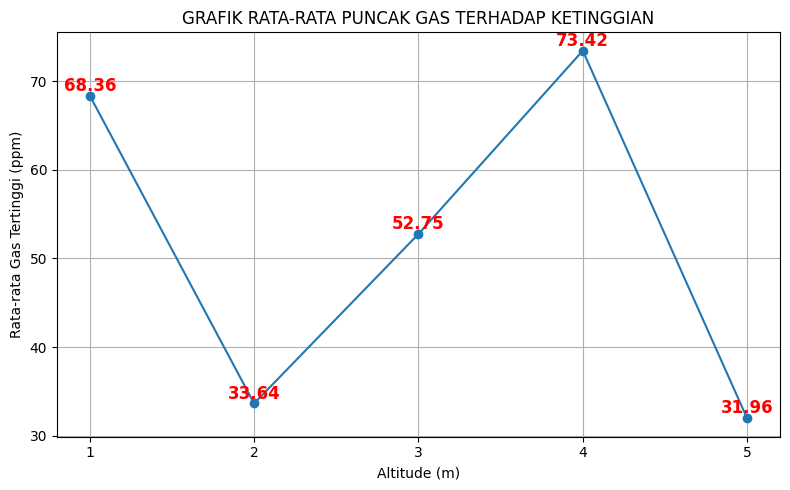

In [24]:
multiple_log.plot_avg_peak()

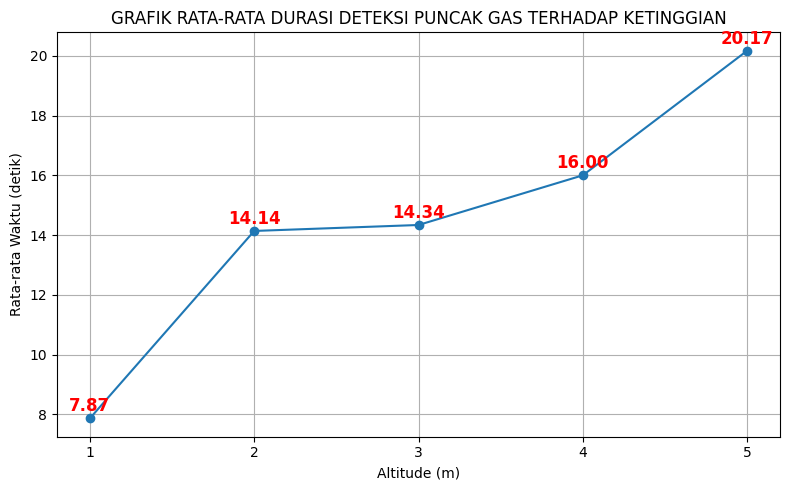

In [25]:
multiple_log.plot_avg_time()

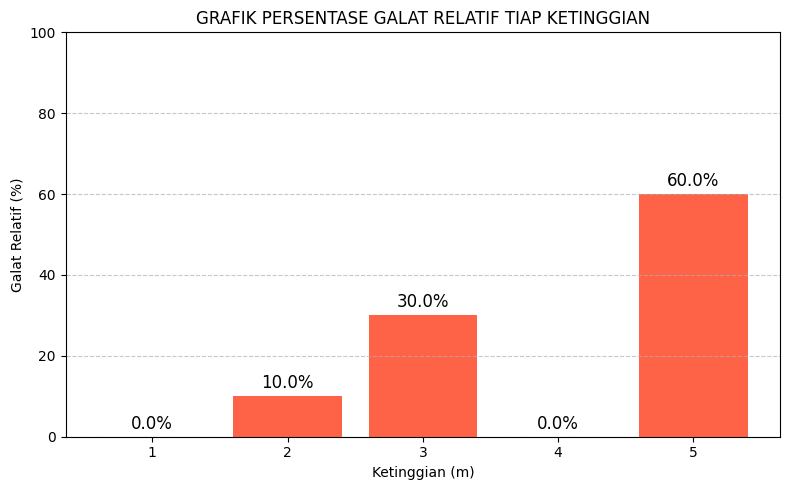

In [26]:
multiple_log.plot_error_relatif()

[INFO] Plotting gas file : 8_1m.bin


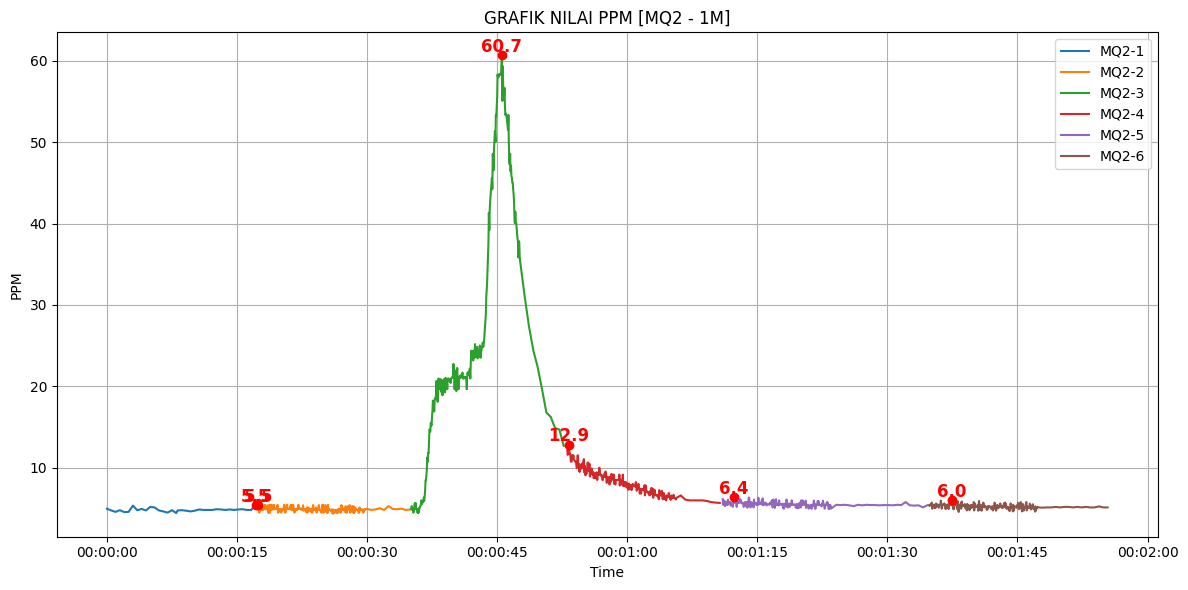

[INFO] Plotting gas file : 8_2m.bin


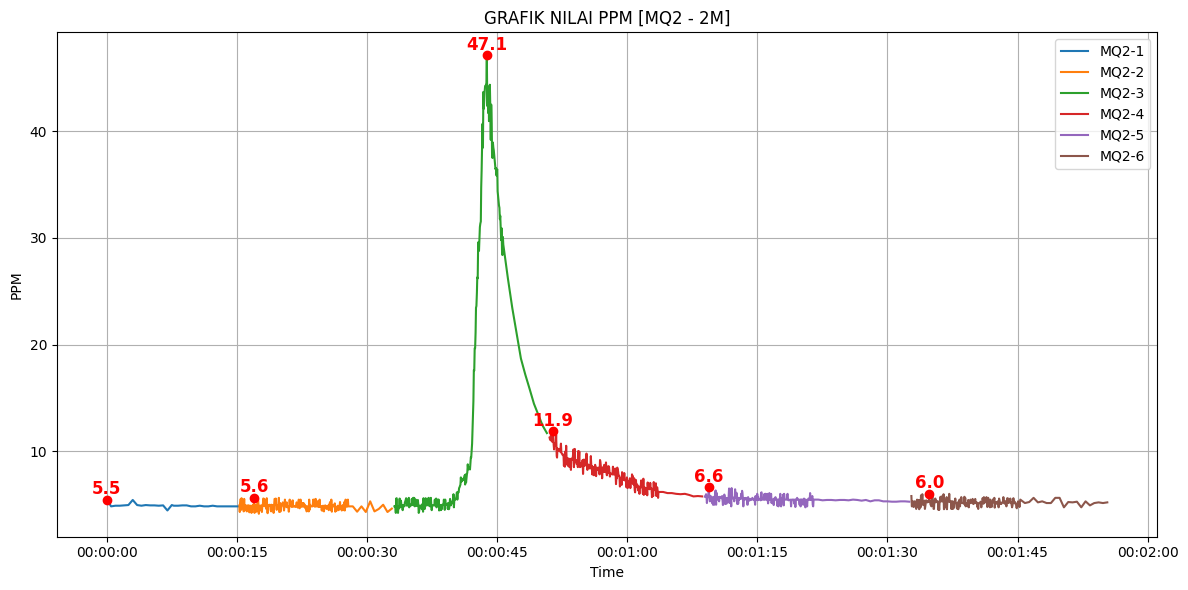

[INFO] Plotting gas file : 8_3m.bin


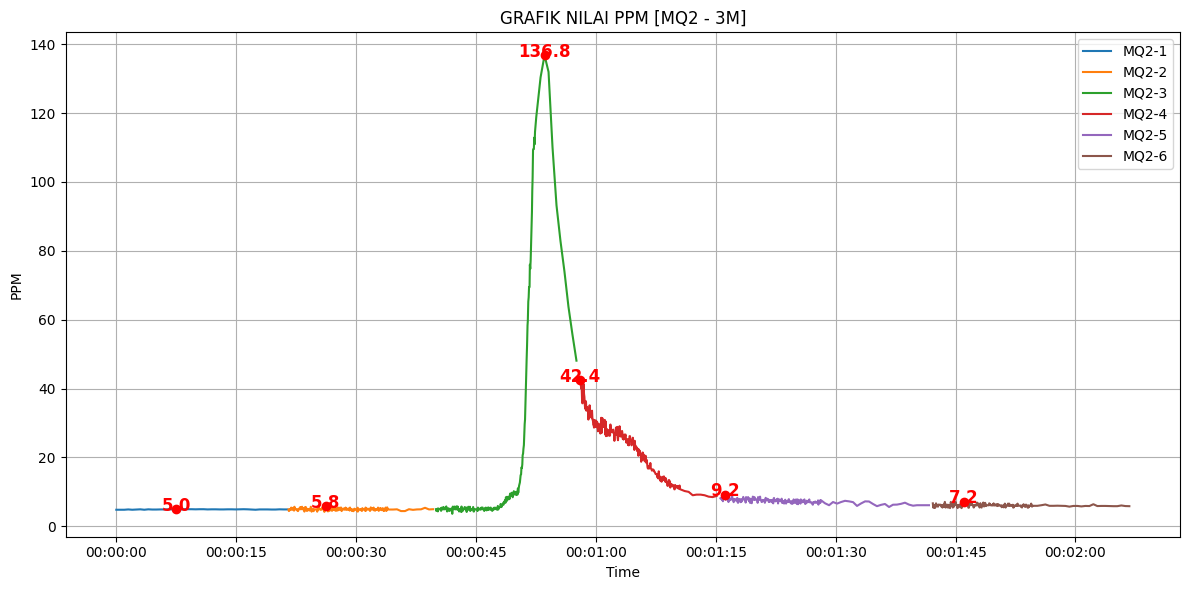

[INFO] Plotting gas file : 8_4m.bin


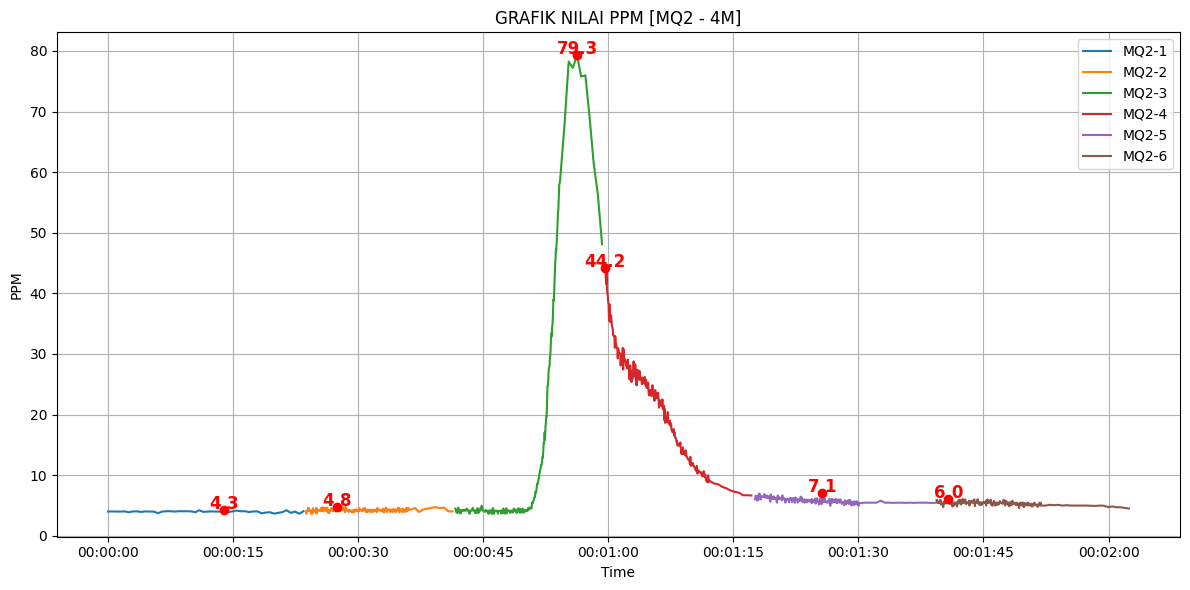

[INFO] Plotting gas file : 8_5m.bin


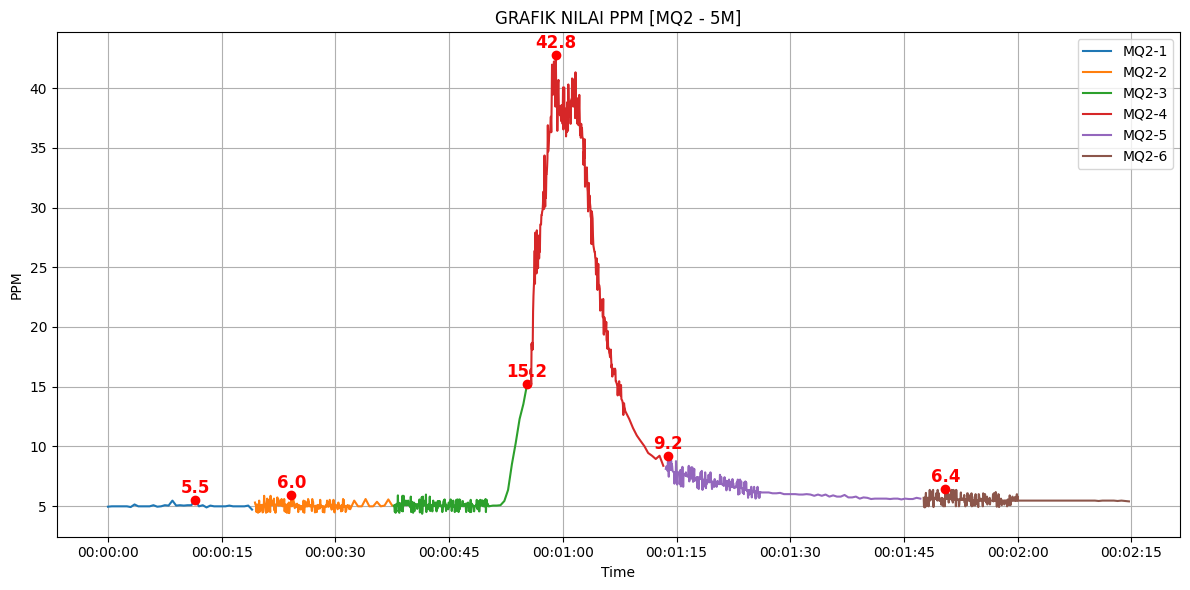

In [27]:
multiple_log.plot_some_gas(experiments_num=8)

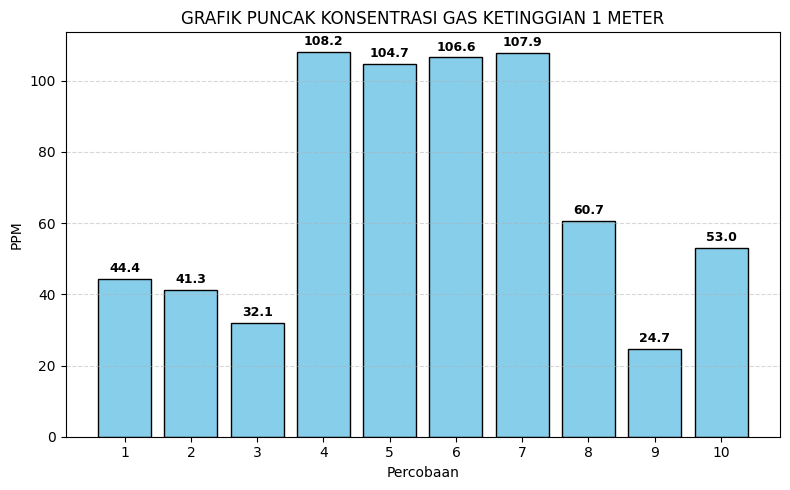

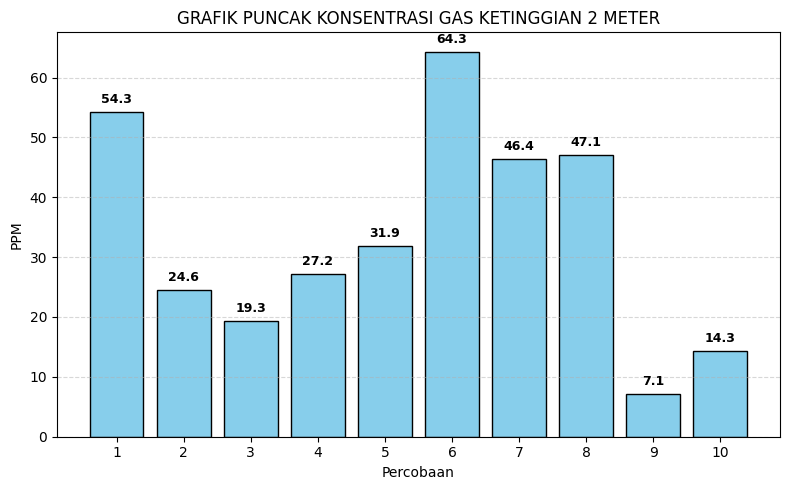

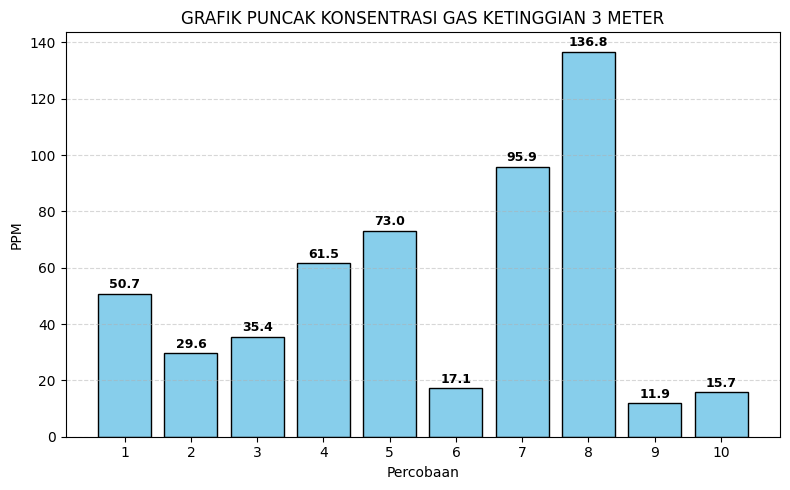

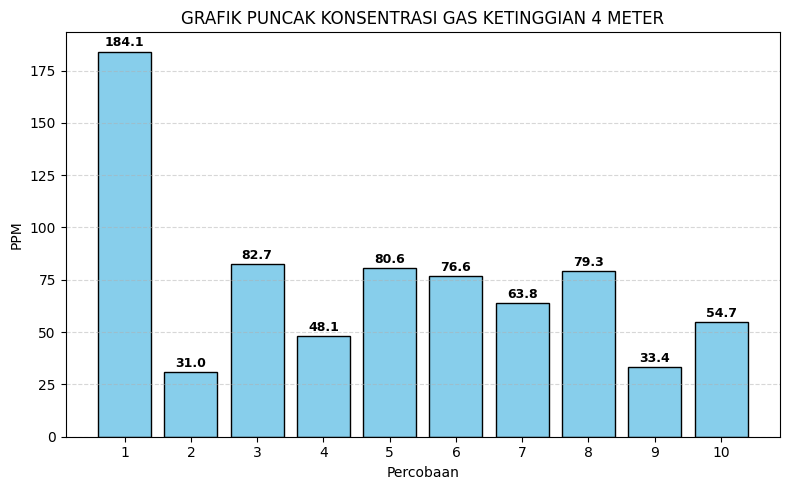

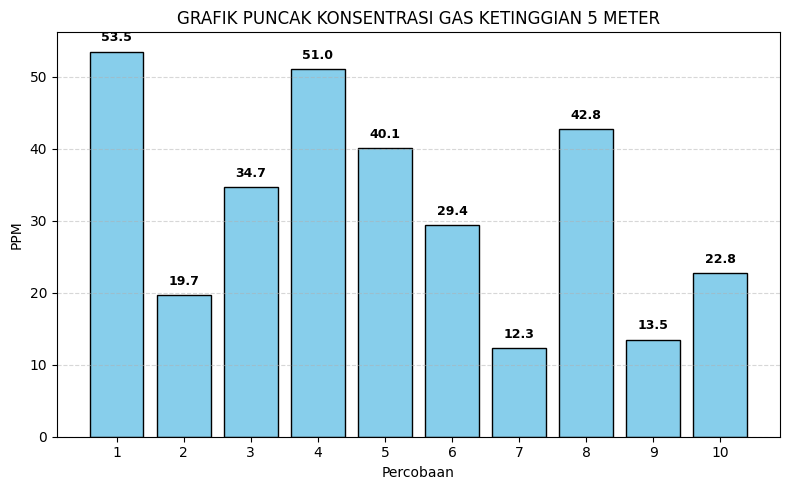

In [28]:
multiple_log.plot_gas_per_alt()

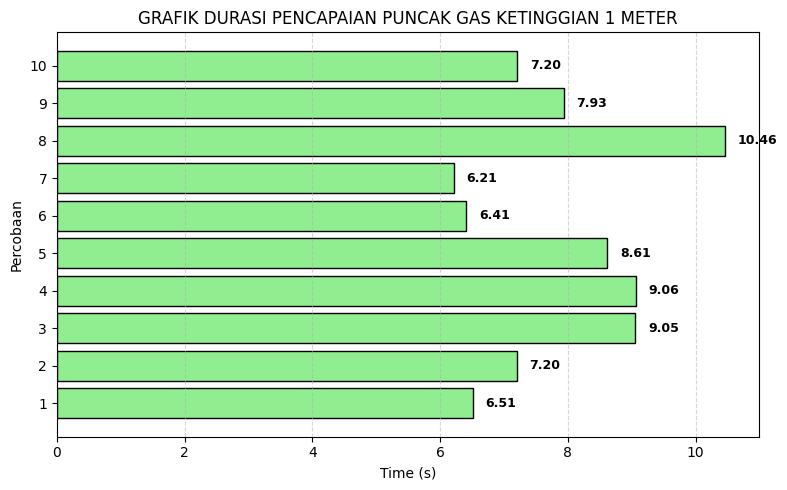

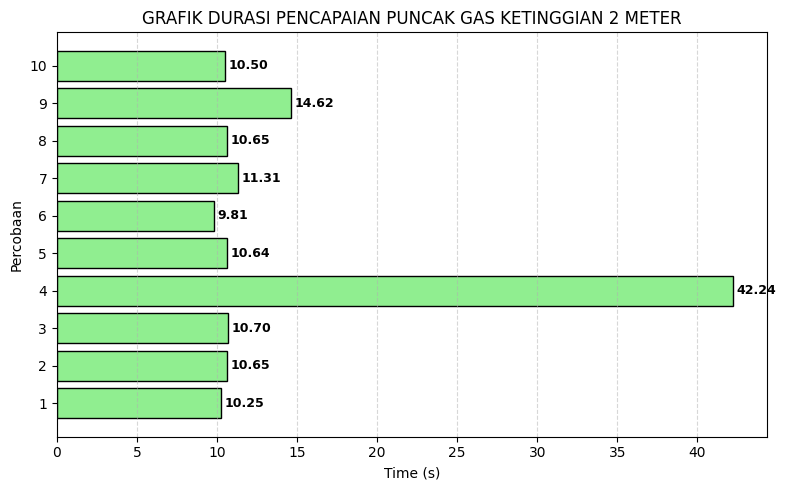

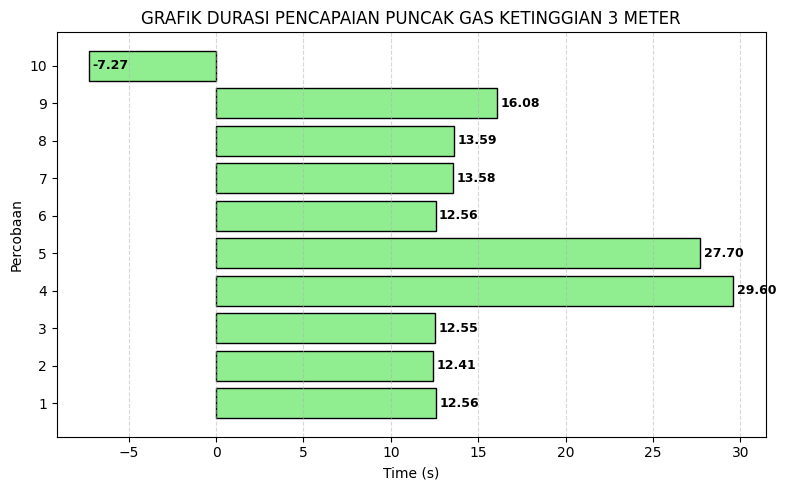

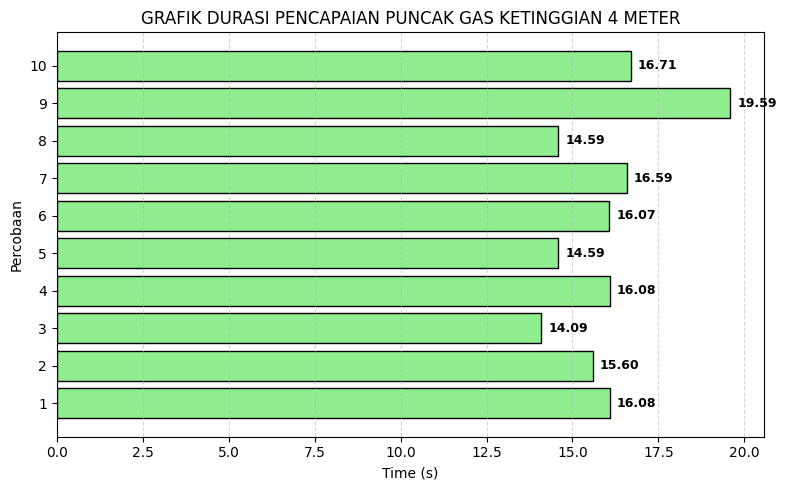

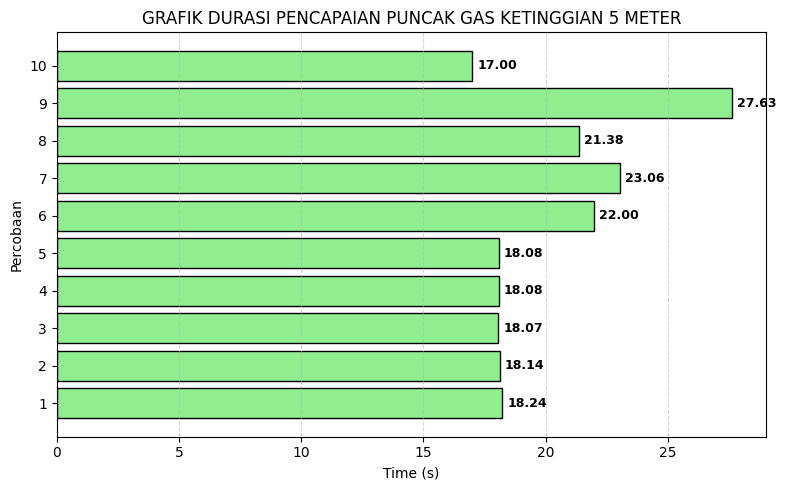

In [29]:
multiple_log.plot_time_per_alt()

### Multiple Logger II - mapping

In [30]:
folder_path = "Log_File/Sampling/Mapping/"
multiple_log = MultipleLogger(folder_path)

In [31]:
ground_truth = [6, 5, 4, 7, 8, 9, 3, 4, 6, 6]
result = multiple_log.get_summary(ground_truth=ground_truth, mapping=True)
result['peak_ppm'] = result['peak_ppm'].round(2)
result['peak_time'] = result['peak_time'].round(2)
result

file  alt sensor  peak_seq  peak_ppm  peak_time
0  10_seq6.bin    4    MQ2         6     44.49      15.08
1   1_seq5.bin    4    MQ2         5     79.50      16.09
2   2_seq4.bin    4    MQ2         4     51.95      16.08
3   3_seq7.bin    4    MQ2         7     82.71      14.58
4   4_seq8.bin    4    MQ2         8     58.47      15.59
5   5_seq9.bin    4    MQ2         9     79.28      13.58
6   6_seq3.bin    4    MQ2         3     74.16      14.09
7   7_seq4.bin    4    MQ2         4     18.62      12.09
8   8_seq6.bin    4    MQ2         6     20.89      13.08
9   9_seq6.bin    4    MQ2         7     18.69      20.55

In [32]:
excel_filename = "Result_Table/Mapping.xlsx"
result.to_excel(excel_filename, index=False)

In [33]:
print(result['peak_ppm'].mean())
print(result['peak_time'].mean())

52.876
15.081000000000003


In [34]:
ground_truth = [6, 5, 4, 7, 8, 9, 3, 4, 6, 6]
multiple_log.get_mapping_result(ground_truth, verbose=False)

index         file  leak_detection  ground_truth  match
0      1  10_seq6.bin               6             6   True
1      2   1_seq5.bin               5             5   True
2      3   2_seq4.bin               4             4   True
3      4   3_seq7.bin               7             7   True
4      5   4_seq8.bin               8             8   True
5      6   5_seq9.bin               9             9   True
6      7   6_seq3.bin               3             3   True
7      8   7_seq4.bin               4             4   True
8      9   8_seq6.bin               6             6   True
9     10   9_seq6.bin               7             6  False

[INFO] Visualization 2D gas file : 10_seq6.bin


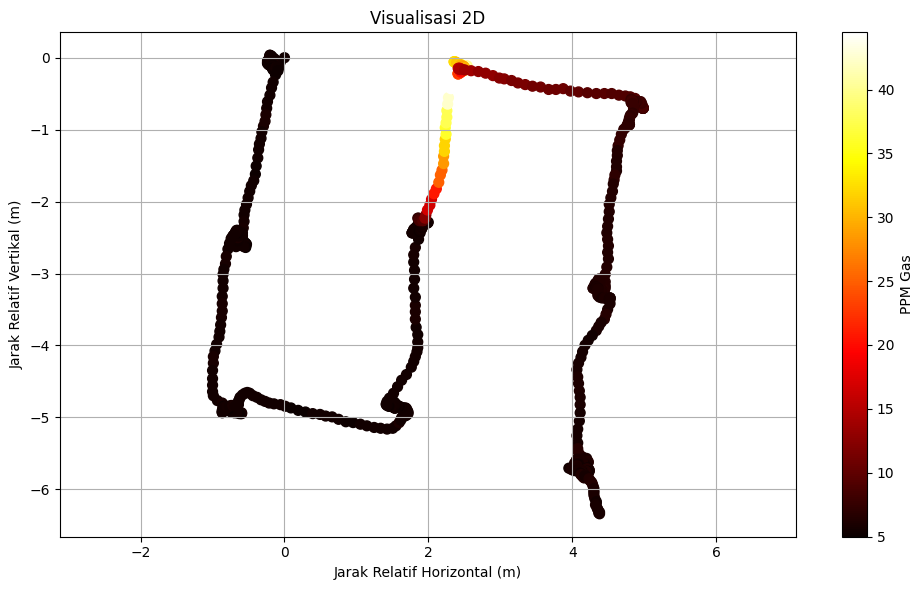

[INFO] Visualization 2D gas file : 1_seq5.bin


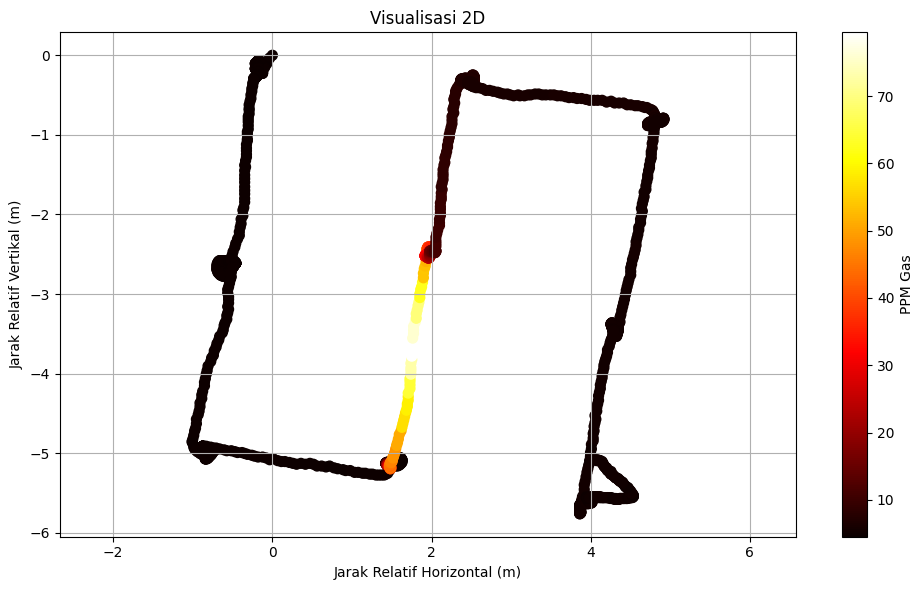

[INFO] Visualization 2D gas file : 2_seq4.bin


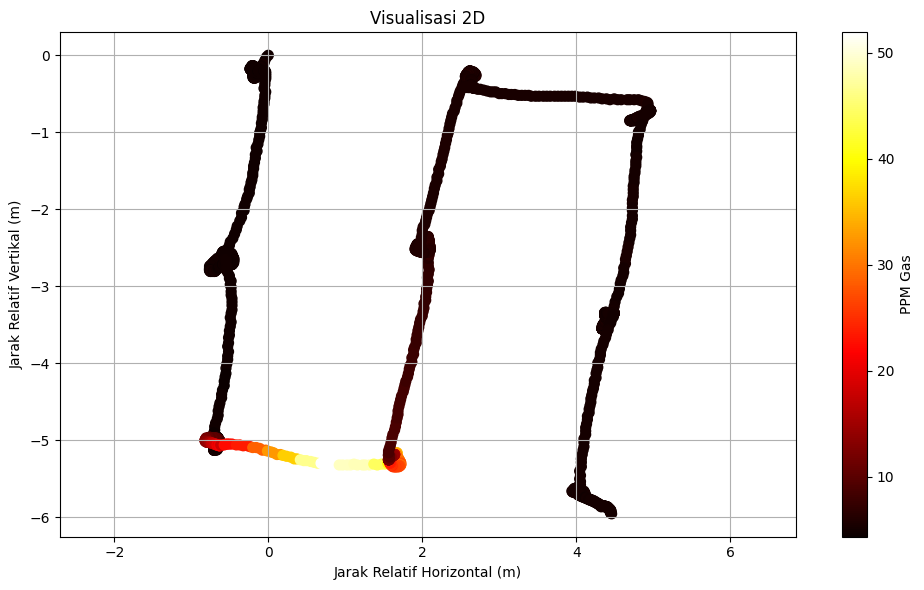

[INFO] Visualization 2D gas file : 3_seq7.bin


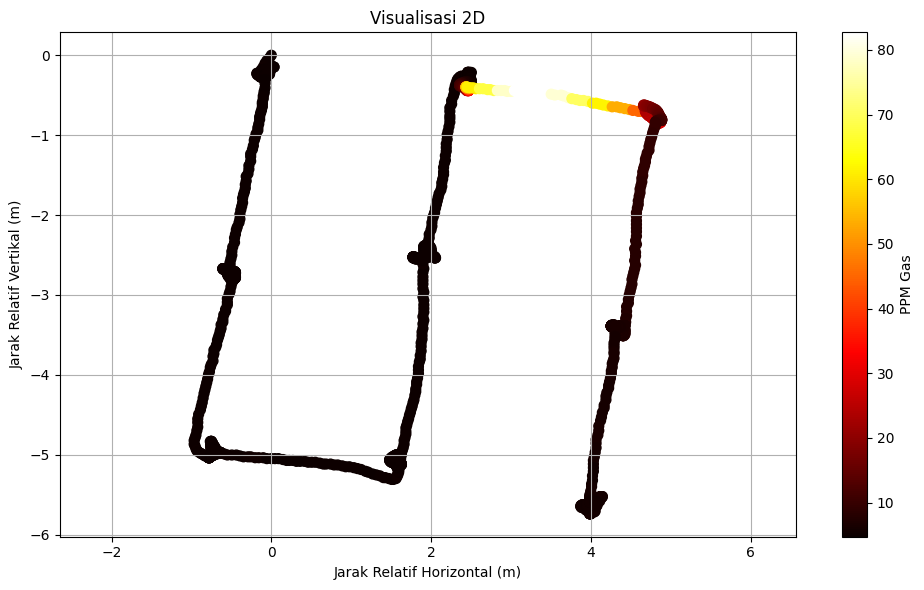

[INFO] Visualization 2D gas file : 4_seq8.bin


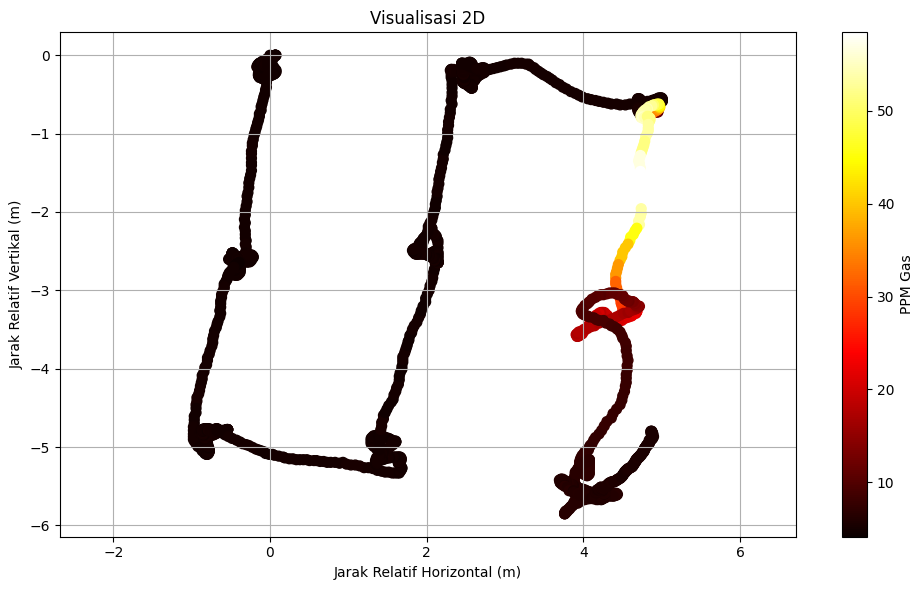

[INFO] Visualization 2D gas file : 5_seq9.bin


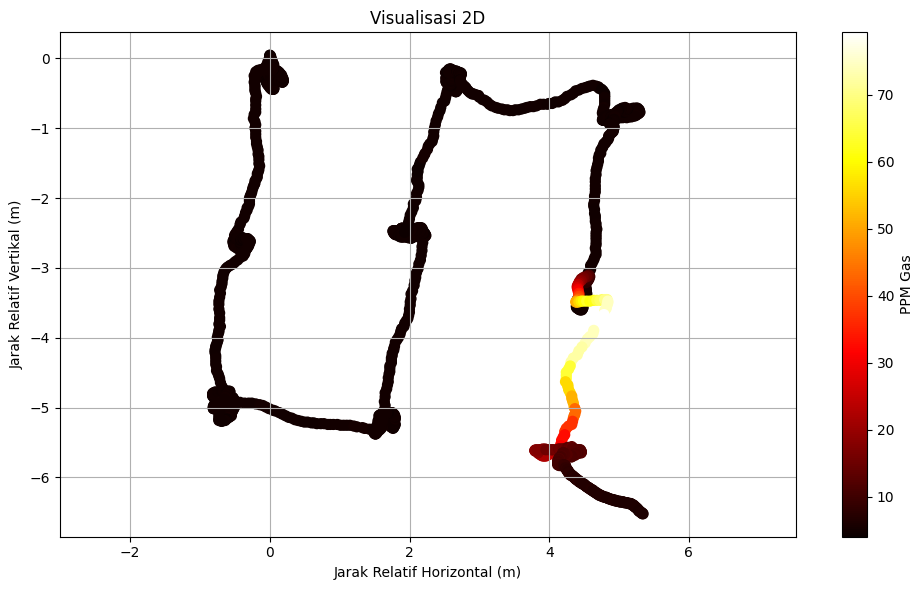

[INFO] Visualization 2D gas file : 6_seq3.bin


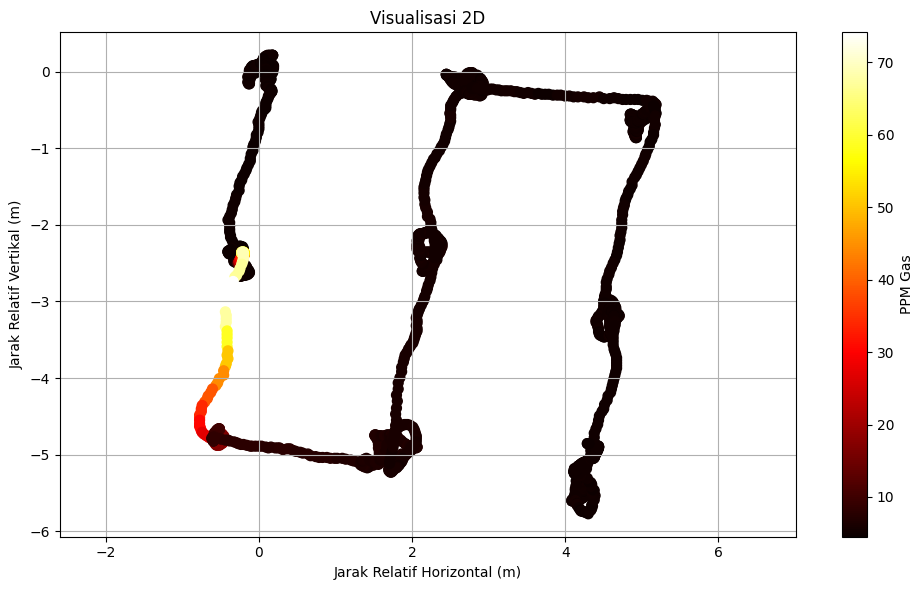

[INFO] Visualization 2D gas file : 7_seq4.bin


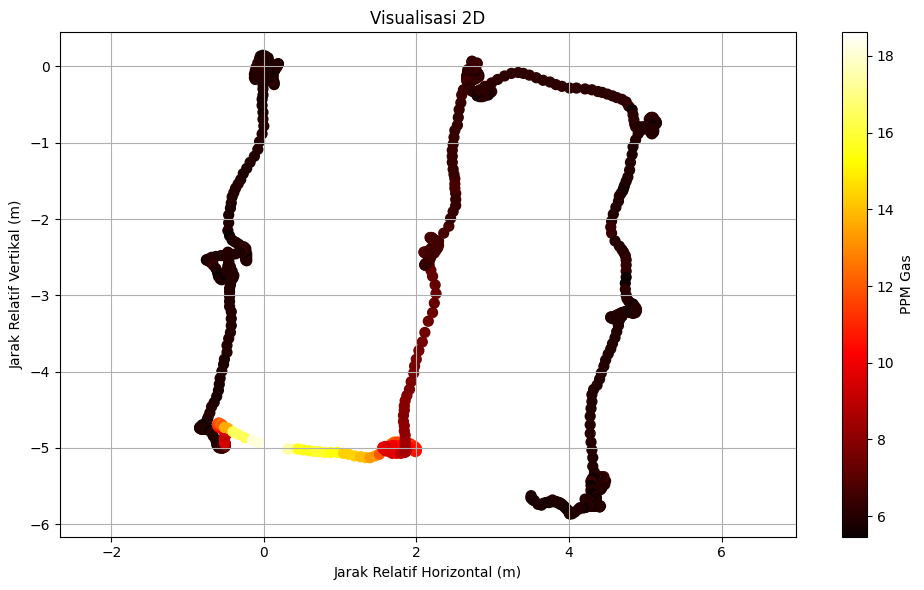

[INFO] Visualization 2D gas file : 8_seq6.bin


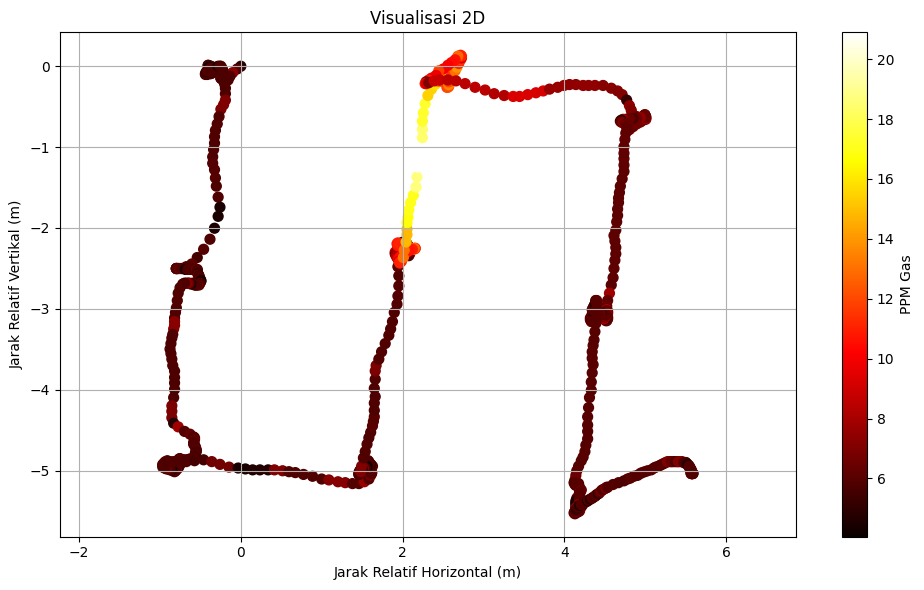

[INFO] Visualization 2D gas file : 9_seq6.bin


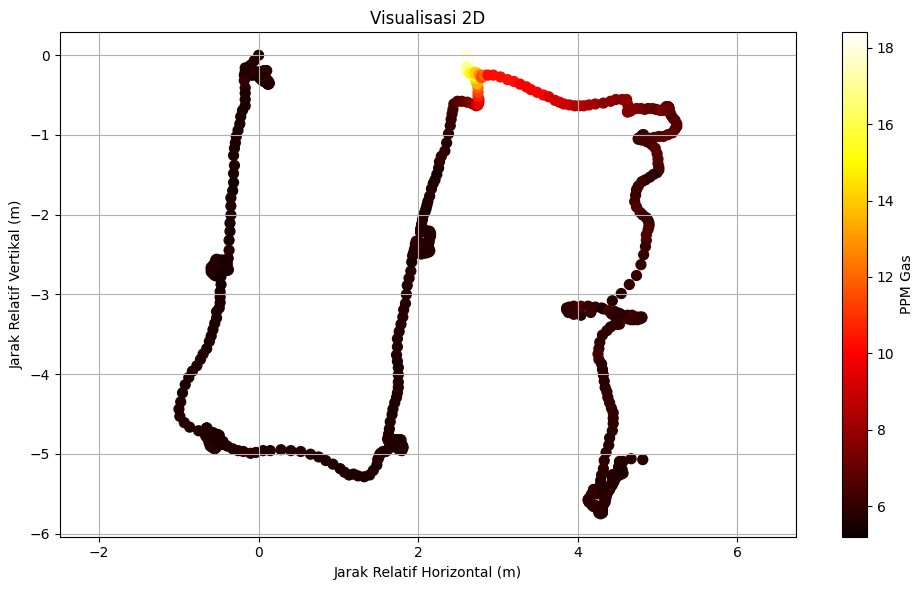

In [35]:
mapping_type = '2D'
multiple_log.mapping_all_gas(mapping_type=mapping_type)

[INFO] Visualization GRID gas file : 10_seq6.bin


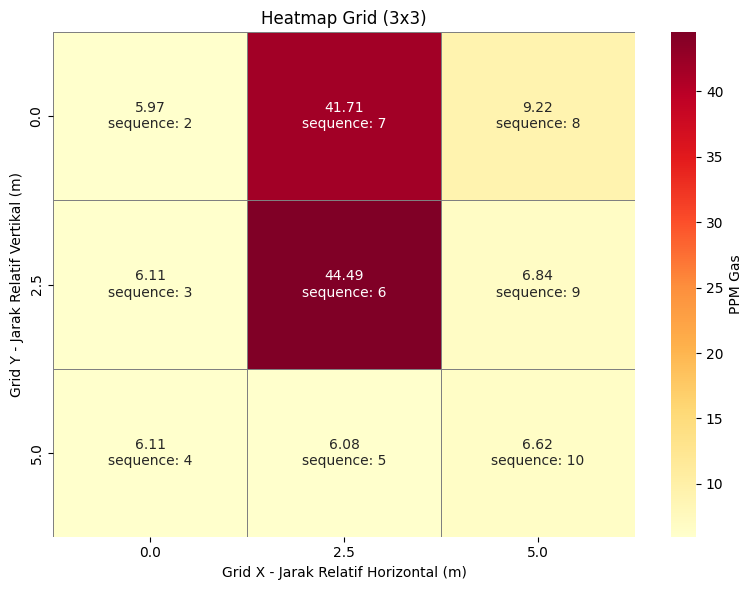

[INFO] Visualization GRID gas file : 1_seq5.bin


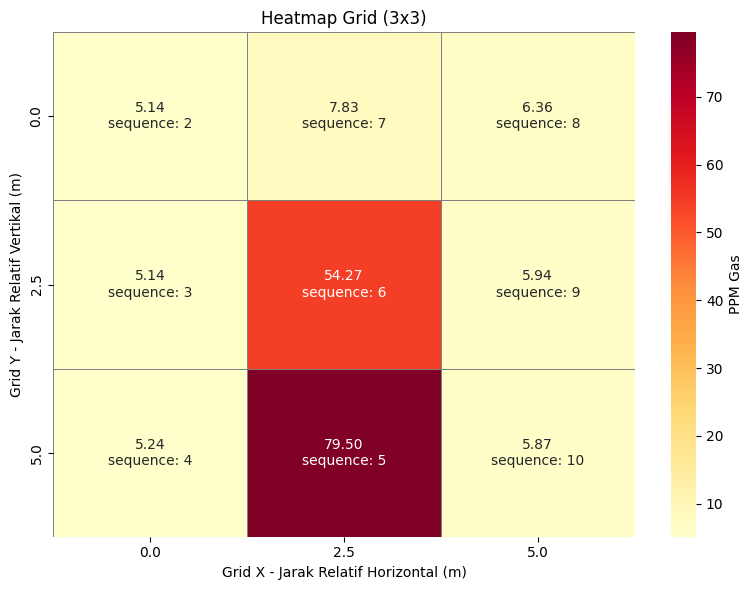

[INFO] Visualization GRID gas file : 2_seq4.bin


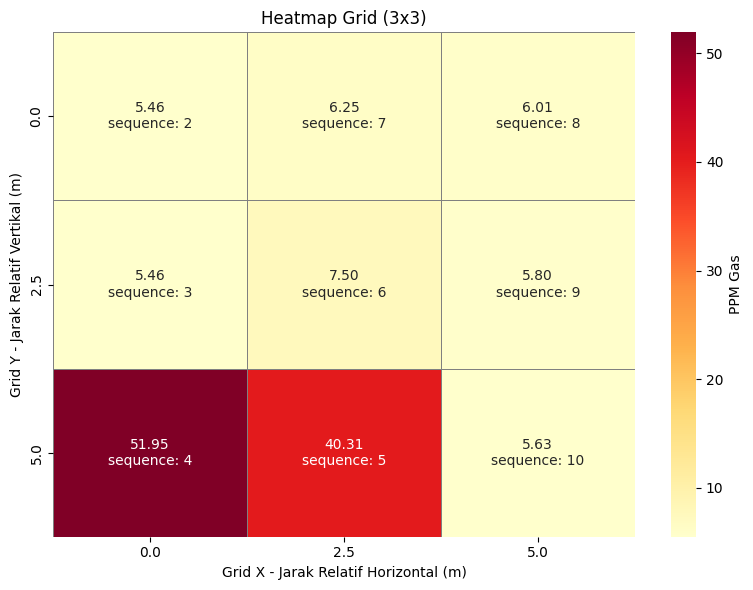

[INFO] Visualization GRID gas file : 3_seq7.bin


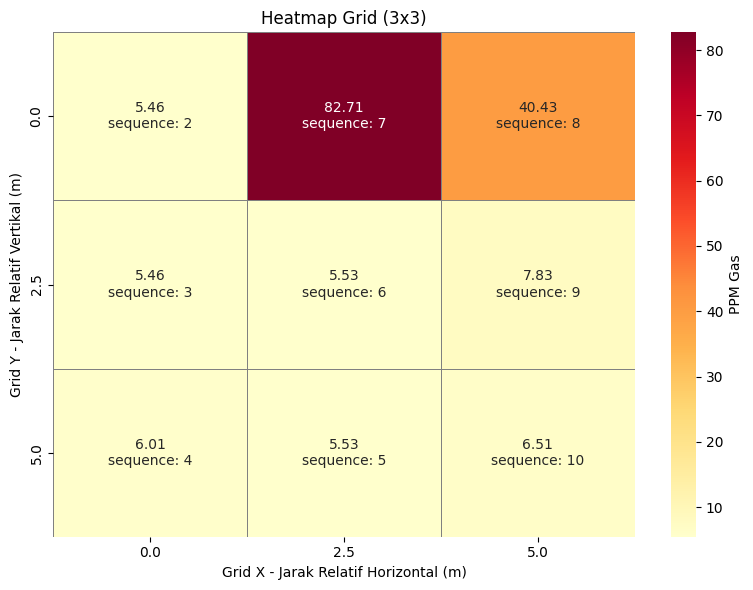

[INFO] Visualization GRID gas file : 4_seq8.bin


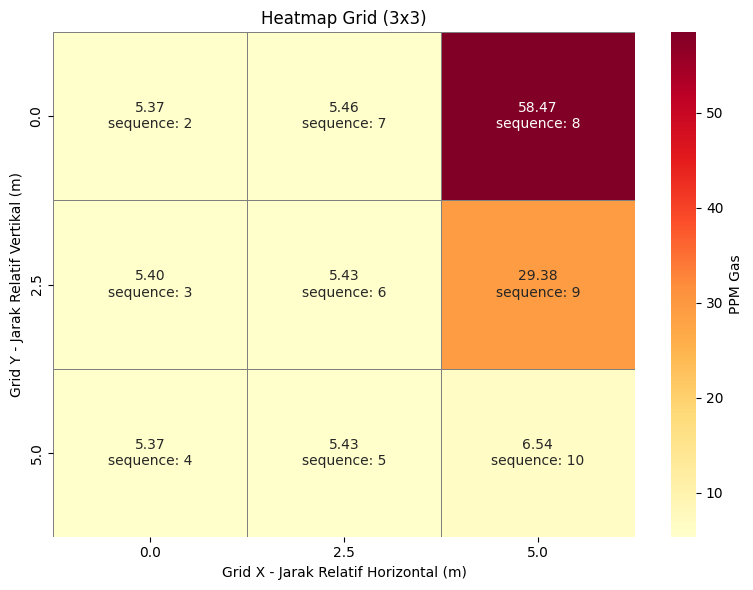

[INFO] Visualization GRID gas file : 5_seq9.bin


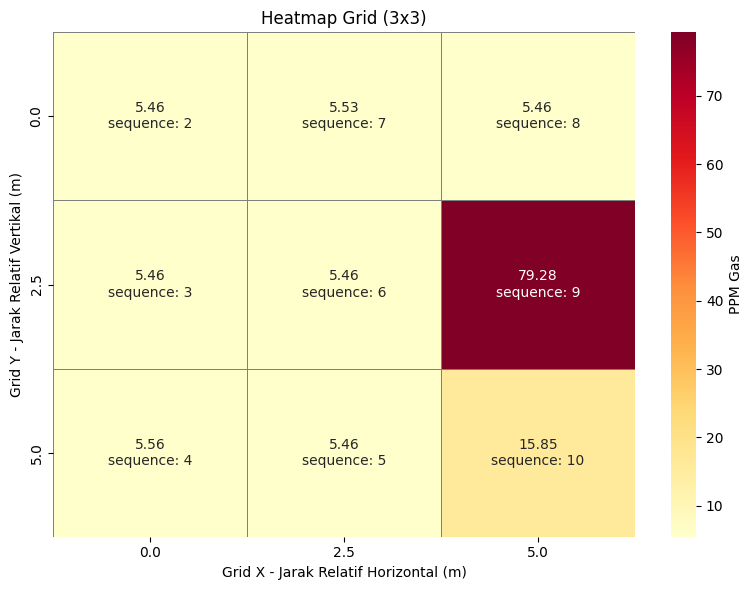

[INFO] Visualization GRID gas file : 6_seq3.bin


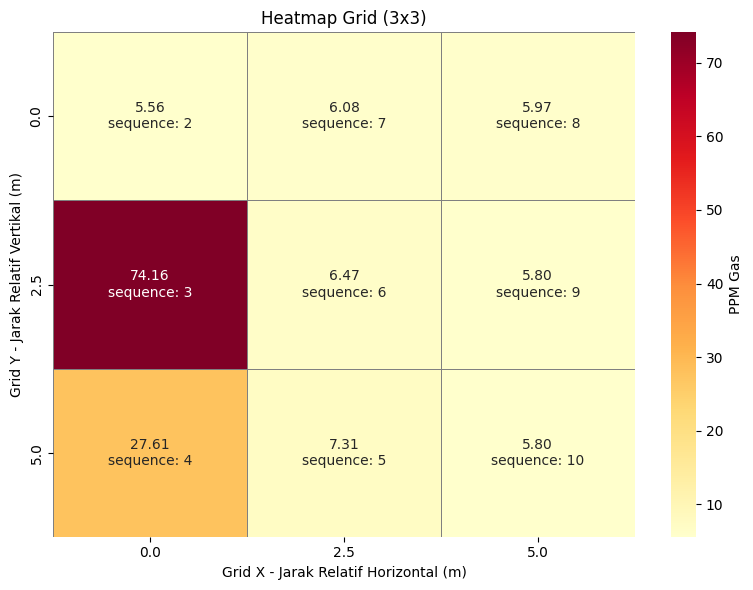

[INFO] Visualization GRID gas file : 7_seq4.bin


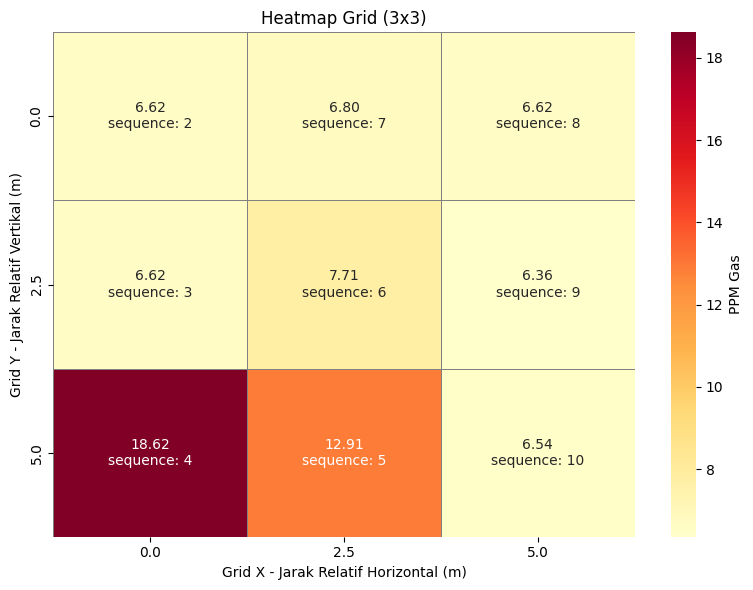

[INFO] Visualization GRID gas file : 8_seq6.bin


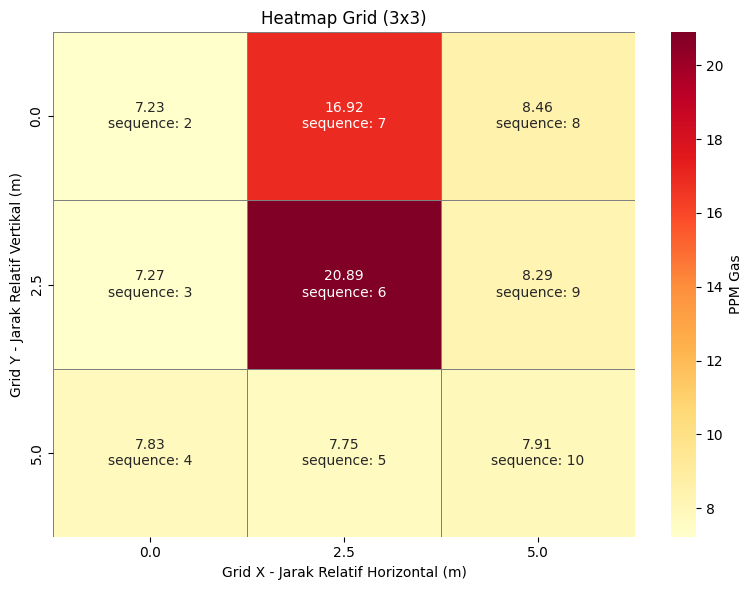

[INFO] Visualization GRID gas file : 9_seq6.bin


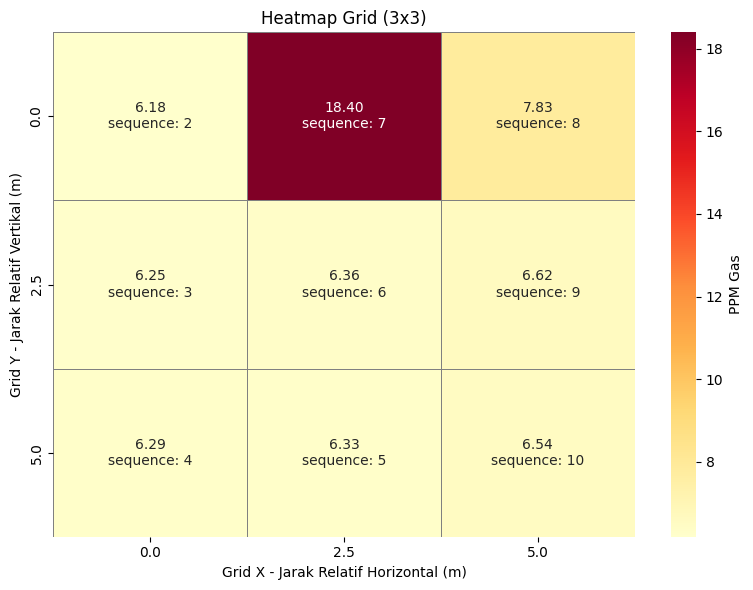

In [36]:
mapping_type = 'GRID'
multiple_log.mapping_all_gas(mapping_type=mapping_type)

[INFO] Plotting gas file : 10_seq6.bin [ground truth: 6]


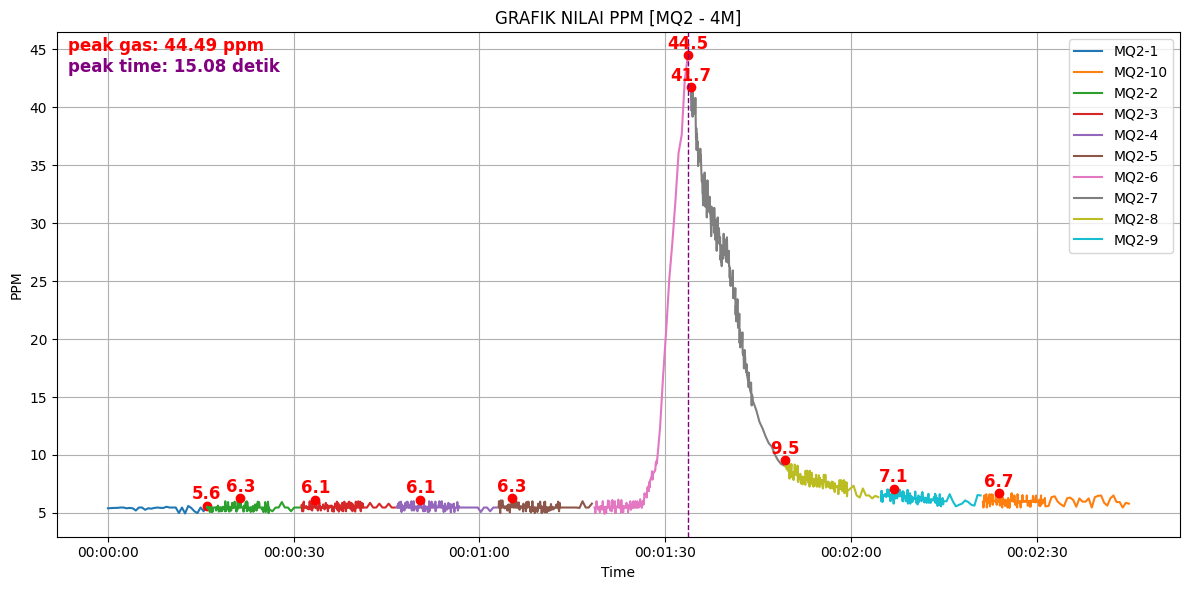

[INFO] Plotting gas file : 1_seq5.bin [ground truth: 5]


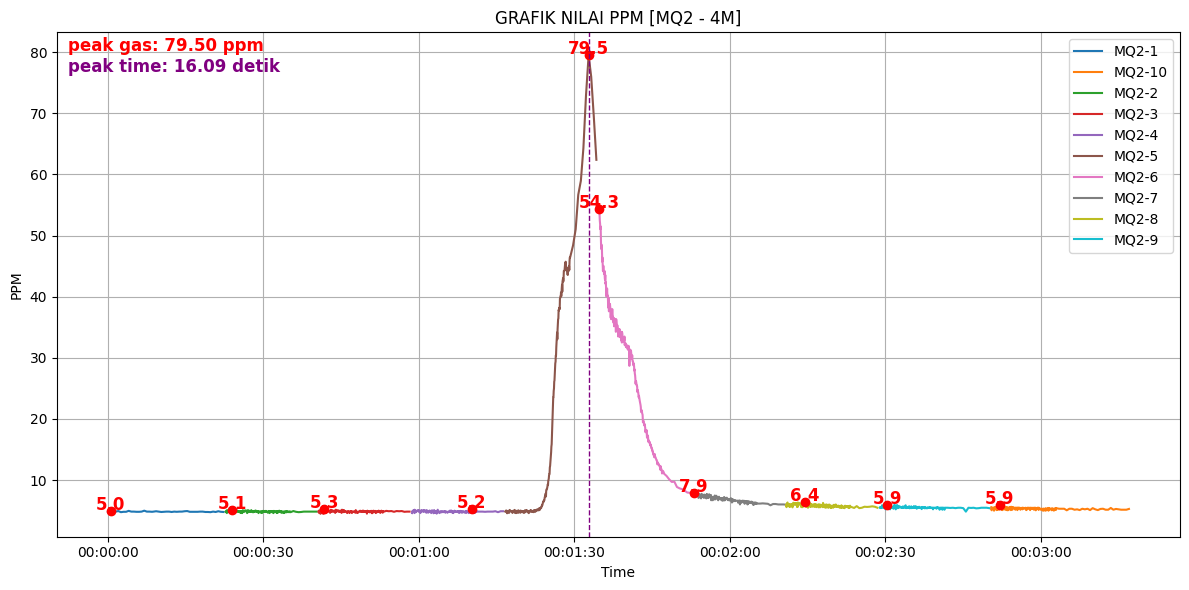

[INFO] Plotting gas file : 2_seq4.bin [ground truth: 4]


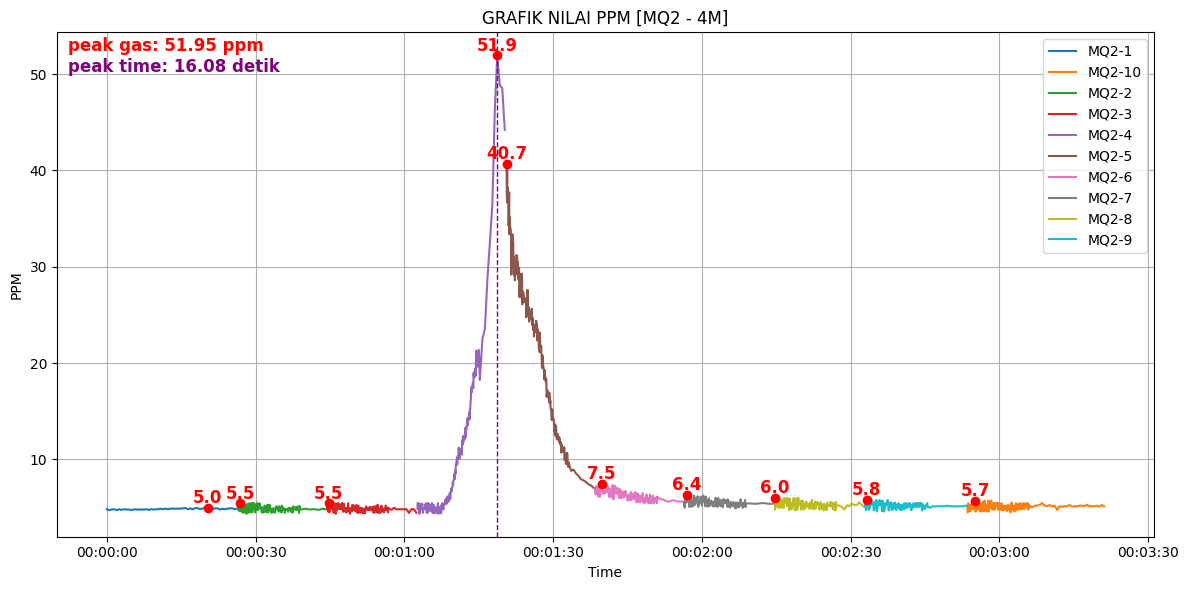

[INFO] Plotting gas file : 3_seq7.bin [ground truth: 7]


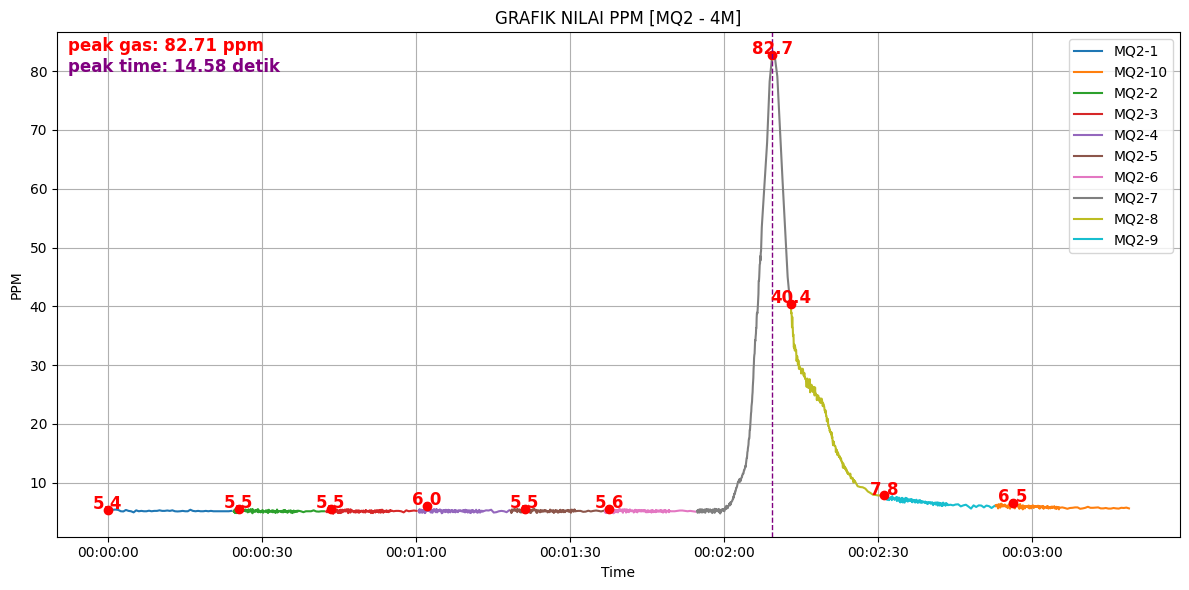

[INFO] Plotting gas file : 4_seq8.bin [ground truth: 8]


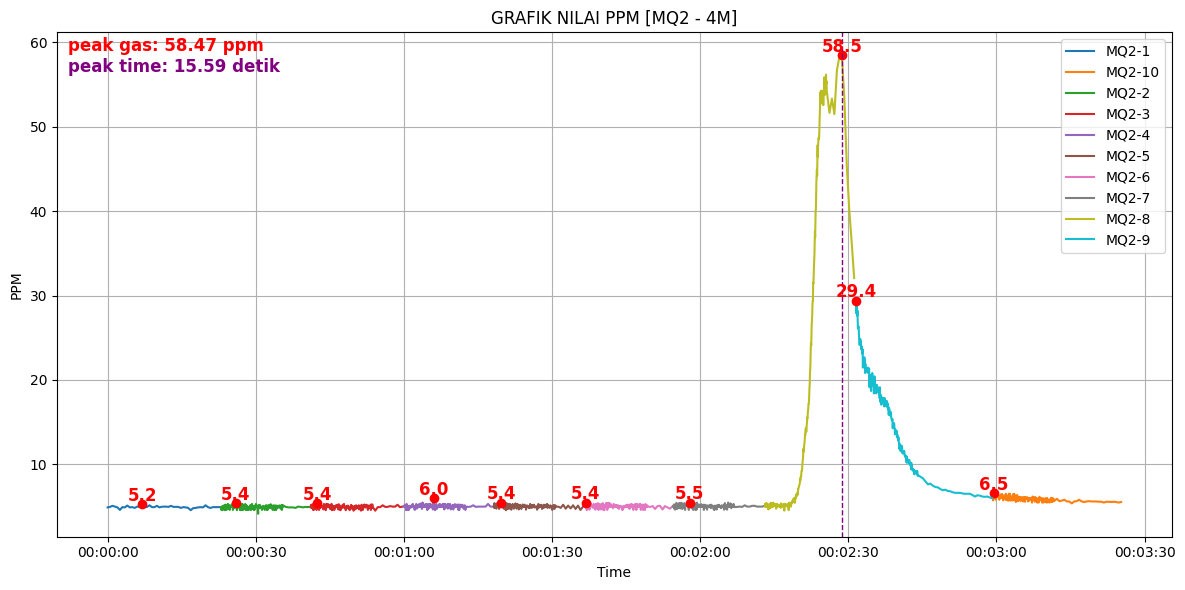

[INFO] Plotting gas file : 5_seq9.bin [ground truth: 9]


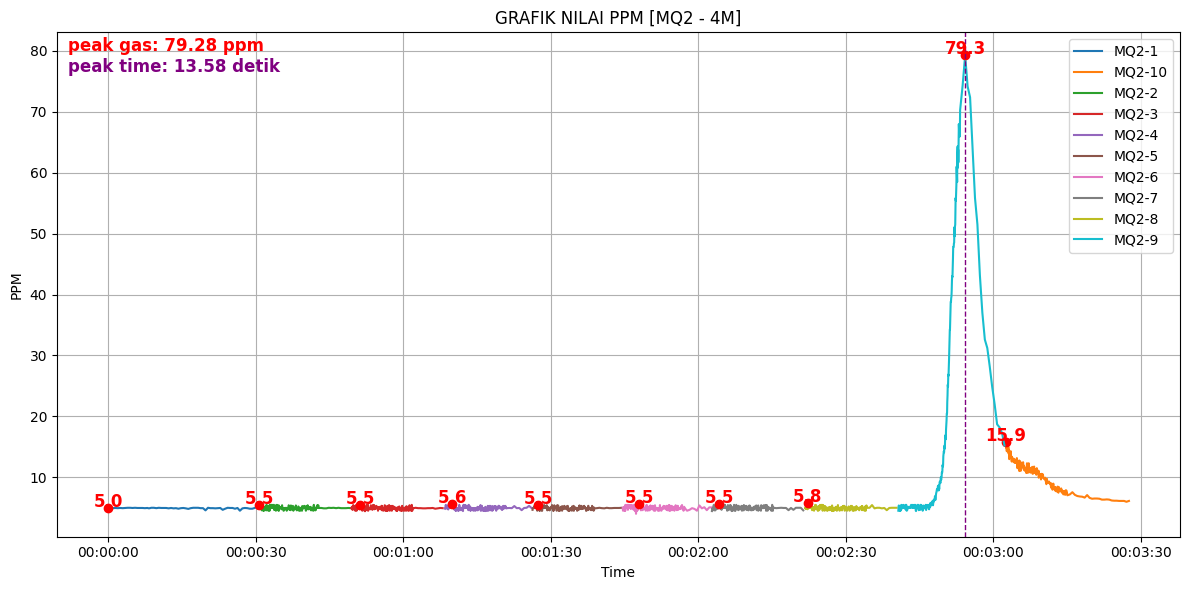

[INFO] Plotting gas file : 6_seq3.bin [ground truth: 3]


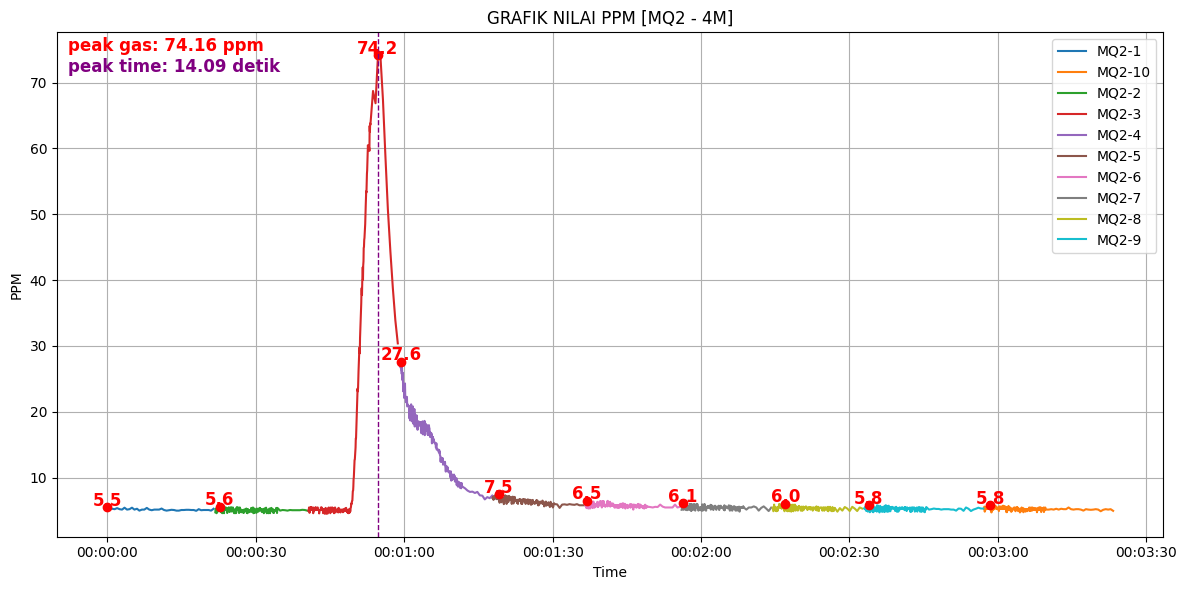

[INFO] Plotting gas file : 7_seq4.bin [ground truth: 4]


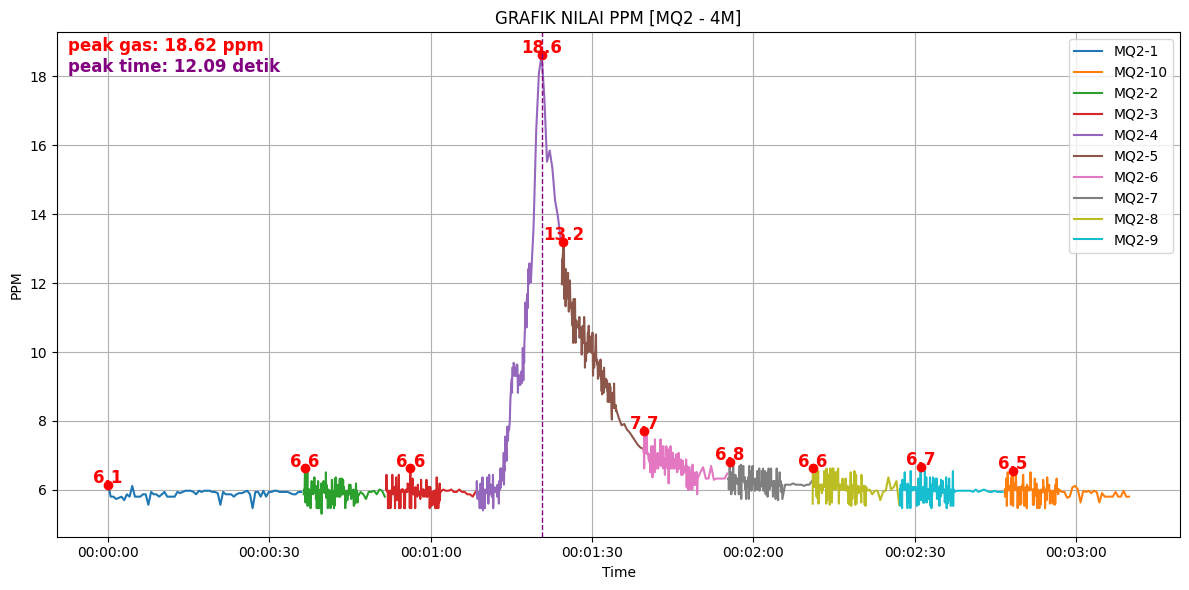

[INFO] Plotting gas file : 8_seq6.bin [ground truth: 6]


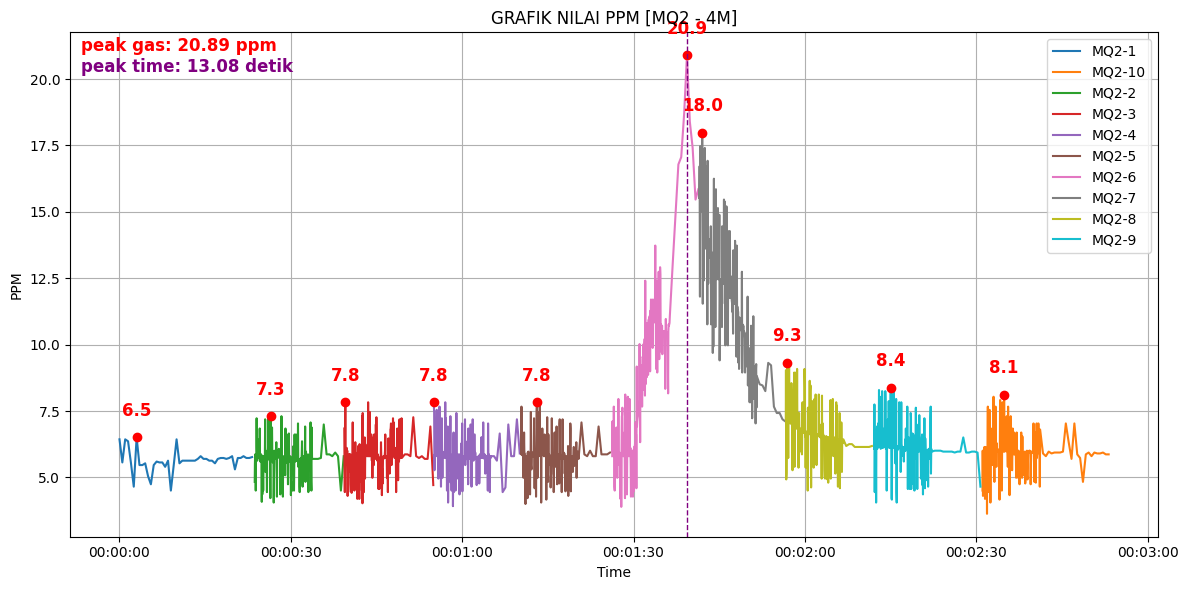

[INFO] Plotting gas file : 9_seq6.bin [ground truth: 6]


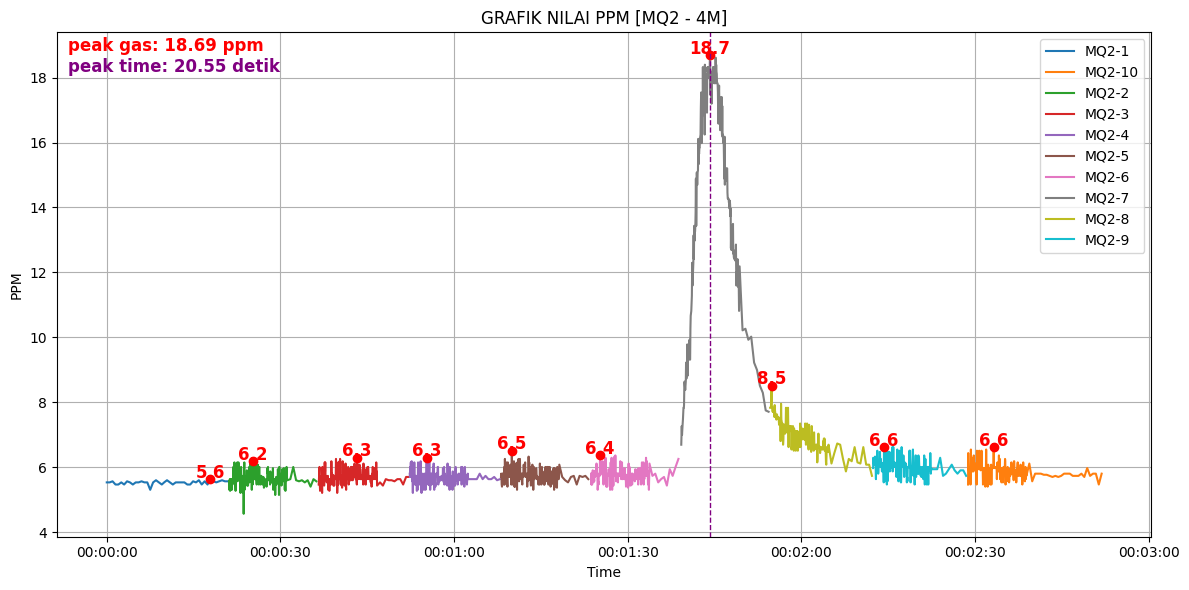

In [37]:
ground_truth = [6, 5, 4, 7, 8, 9, 3, 4, 6, 6]
multiple_log.plot_all_gas(verbose_graph=True, ground_truth=ground_truth, mapping=True)